<a href="https://colab.research.google.com/github/akkiaryan/co2-temperature-coupling-pipeline/blob/main/CO2emm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**📘 Phase One — Data Ingestion & Harmonization**

**Description**

In this phase, we set up the Google Drive workspace and enforce a reproducible folder structure for the CO₂ pipeline project.
We then create a Data Registry (DATA_REGISTRY.csv) — a manifest that records each dataset’s path, description, units, and license.
Finally, we ingest all raw files (OWID, EDGAR, Cement, Fossil, UNFCCC, Global, Temperature), harmonize their schema (ISO code, country, year, emissions), apply a sector name harmonizer, and save clean versions into /processed/ as Parquet files.

Goals of Phase One:

	•	Mount Google Drive for persistent storage.
	•	Enforce the CO₂ folder layout (raw, processed, models, outputs).
	•	Centralize dataset metadata in one registry (easy to extend later).
	•	Convert raw files with inconsistent formats into standardized tables with consistent columns.
	•	Prepare a master_panel.parquet with country, year, total emissions, sector splits, and optional temperature anomalies.

**1) Mount & folder layout**

In [ ]:
# --- Colab & Drive setup ---
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
import pandas as pd
import numpy as np
import json, shutil, sys, os, datetime

DRIVE_ROOT = Path('/content/drive/MyDrive')
BASE = DRIVE_ROOT / 'CO2'
RAW = BASE / 'raw'
PROC = BASE / 'processed'
MODELS = BASE / 'models'
OUT = BASE / 'outputs'

for p in [RAW, PROC, MODELS, OUT]:
    p.mkdir(parents=True, exist_ok=True)

# Recommended raw structure (create dirs only; you will drop files there)
for sub in ['owid','edgar','cement','fossil','unfccc','global','temp']:
    (RAW / sub).mkdir(parents=True, exist_ok=True)

print(f"✅ Base folder ready at: {BASE}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Base folder ready at: /content/drive/MyDrive/CO2


**2) Registry (single source of truth)**

In [ ]:
# --- DATA_REGISTRY.csv template (idempotent) ---
REG = BASE / 'DATA_REGISTRY.csv'

template = pd.DataFrame([
    dict(source_id='owid',   filename='owid-co2-data.csv',
         relative_path='raw/owid/owid-co2-data.csv',
         description='Our World in Data master CO₂ dataset (totals, per capita, consumption-based)',
         format='csv', units='MtCO2', license='CC-BY', last_updated=str(datetime.date.today())),
    dict(source_id='edgar',  filename='edgar-co2-emissions.csv',
         relative_path='raw/edgar/edgar-co2-emissions.csv',
         description='EDGAR sectoral CO₂ emissions by country',
         format='csv', units='MtCO2', license='JRC/EDGAR', last_updated=str(datetime.date.today())),
    dict(source_id='cement', filename='cement-emissions.csv',
         relative_path='raw/cement/cement-emissions.csv',
         description='Cement process CO₂ emissions',
         format='csv', units='MtCO2', license='OpenClimateData', last_updated=str(datetime.date.today())),
    dict(source_id='fossil', filename='fossil-fuel-co2-emissions-by-nation.csv',
         relative_path='raw/fossil/fossil-fuel-co2-emissions-by-nation.csv',
         description='Fossil-fuel CO₂ by country (long-run)',
         format='csv', units='MtCO2', license='Open (datasets repo)', last_updated=str(datetime.date.today())),
    dict(source_id='unfccc', filename='unfccc-2017.csv',
         relative_path='raw/unfccc/unfccc-2017.csv',
         description='UNFCCC national inventory submissions (2017 snapshot)',
         format='csv', units='MtCO2', license='UNFCCC', last_updated=str(datetime.date.today())),
    dict(source_id='global', filename='global.csv',
         relative_path='raw/global/global.csv',
         description='Global total CO₂ emissions summary',
         format='csv', units='MtCO2', license='check source', last_updated=str(datetime.date.today())),
    dict(source_id='temp',   filename='climate_change_download_0.xls',
         relative_path='raw/temp/climate_change_download_0.xls',
         description='Country-level climate/temperature anomaly data',
         format='xls', units='degC_anomaly', license='check source', last_updated=str(datetime.date.today())),
])

if not REG.exists():
    template.to_csv(REG, index=False)
    print(f"🗂 Created registry: {REG}")
else:
    print(f"🗂 Registry already exists: {REG}")
    print(pd.read_csv(REG).head())

🗂 Registry already exists: /content/drive/MyDrive/CO2/DATA_REGISTRY.csv
  source_id                                 filename  \
0      owid                        owid-co2-data.csv   
1     edgar                  edgar-co2-emissions.csv   
2    cement                     cement-emissions.csv   
3    fossil  fossil-fuel-co2-emissions-by-nation.csv   
4    unfccc                          unfccc-2017.csv   

                                       relative_path  \
0                         raw/owid/owid-co2-data.csv   
1                  raw/edgar/edgar-co2-emissions.csv   
2                    raw/cement/cement-emissions.csv   
3  raw/fossil/fossil-fuel-co2-emissions-by-nation...   
4                         raw/unfccc/unfccc-2017.csv   

                                         description format  units  \
0  Our World in Data master CO₂ dataset (totals, ...    csv  MtCO2   
1            EDGAR sectoral CO₂ emissions by country    csv  MtCO2   
2                       Cement process CO₂ e

**3) Ingestion + validation + sector harmonizer (no modeling yet)**

In [ ]:
# --- Phase One · Block 3 (Rectified + Stable WB temp) ---
import pandas as pd, numpy as np, datetime as _dt, re
from pathlib import Path

BASE = Path('/content/drive/MyDrive/CO2')
RAW  = BASE / 'raw'
PROC = BASE / 'processed'
REG_PATH = BASE / 'DATA_REGISTRY.csv'

assert REG_PATH.exists(), "DATA_REGISTRY.csv not found. Run the registry cell first."
REG = pd.read_csv(REG_PATH)

# -----------------------
# Config / Helpers
# -----------------------
SECTOR_MAP = {
    'Power Industry':'Power','Energy Industry':'Power','Electricity':'Power',
    'Public Electricity and Heat Production':'Power','Power':'Power',
    'Road Transport':'Transport','Aviation':'Transport','Marine':'Transport',
    'Shipping':'Transport','Railways':'Transport','Transport':'Transport',
    'Residential':'Buildings','Commercial':'Buildings','Buildings':'Buildings',
    'Manufacturing':'Industry','Industrial Combustion':'Industry','Industry':'Industry',
    'Other Fuel Combustion':'Other','Other':'Other'
}

def _read_any(row):
    path = BASE / row['relative_path']
    if not path.exists():
        raise FileNotFoundError(f"Missing file: {path}")
    fmt = str(row.get('format','csv')).lower()
    if fmt == 'csv':
        return pd.read_csv(path)
    if fmt in ('xls','xlsx'):
        try:
            return pd.read_excel(path, header=0)
        except Exception:
            return pd.read_excel(path)
    raise ValueError(f"Unsupported format for {path}: {fmt}")

def _coerce_year_col(df):
    candidates = [c for c in df.columns if str(c).strip().lower() in ('year','yr')]
    if candidates:
        df = df.rename(columns={c:'year' for c in candidates})
        return df
    for c in df.columns:
        if pd.api.types.is_integer_dtype(df[c]) and df[c].min()>=1750 and df[c].max()<=2100:
            return df.rename(columns={c:'year'})
    return df

def _wide_year_columns(df):
    yearish = [c for c in df.columns if re.fullmatch(r'\d{4}', str(c))]
    return len(yearish) >= max(5, int(0.4*len(df.columns)))

def _wide_country_columns(df):
    has_year = any(str(c).strip().lower()=='year' for c in df.columns)
    if not has_year:
        return False
    others = [c for c in df.columns if str(c).strip().lower()!='year']
    bad = [c for c in others if not re.fullmatch(r'\d{4}', str(c))]
    return len(bad) >= max(5, int(0.4*len(df.columns)))

def _melt_years_wide(df, value_name):
    df = df.copy()
    df = _coerce_year_col(df)

    # Case A: 'year' + many country columns
    if 'year' in df.columns and _wide_country_columns(df):
        id_vars = ['year']
        # prefer an existing country column name if present
        for cname in df.columns:
            if str(cname).lower() == 'country' and cname != 'country':
                df = df.rename(columns={cname:'country'})
        if 'country' in df.columns:
            id_vars.append('country')
        val_vars = [c for c in df.columns if c not in id_vars]
        long = df.melt(id_vars=id_vars, value_vars=val_vars, var_name='country_maybe', value_name=value_name)
        if 'country' not in long.columns:
            long = long.rename(columns={'country_maybe':'country'})
        else:
            extra = long[['year','country_maybe',value_name]][long['country_maybe'].notna()].rename(columns={'country_maybe':'country'})
            base  = long[['year','country',value_name]]
            long = pd.concat([base, extra], ignore_index=True)
        return long

    # Case B: columns are years, id columns are country/iso
    year_cols = [c for c in df.columns if re.fullmatch(r'\d{4}', str(c))]
    if len(year_cols) >= 5:
        country_col = None; iso_col = None
        for c in df.columns:
            lc = str(c).lower()
            if lc in ('country','name','entity','country name'):
                country_col = c
            if lc in ('iso','iso3','iso_code','code','country code'):
                iso_col = c
        id_vars = []
        if country_col: id_vars.append(country_col)
        if iso_col:     id_vars.append(iso_col)
        long = df.melt(id_vars=id_vars, value_vars=year_cols, var_name='year', value_name=value_name)
        long['year'] = pd.to_numeric(long['year'], errors='coerce').astype('Int64')
        if country_col and country_col != 'country':
            long = long.rename(columns={country_col:'country'})
        if iso_col and iso_col != 'iso_code':
            long = long.rename(columns={iso_col:'iso_code'})
        return long

    return df

def _units_to_mt(s):
    v = pd.to_numeric(s, errors='coerce')
    med = v.dropna().median() if v.notna().any() else np.nan
    if pd.isna(med): return v
    if med > 1e6:  return v/1e6   # tonnes
    if med > 1e3:  return v/1e3   # kt
    return v       # already Mt

def _finalize(df, dataset_tag, sector=None):
    if 'iso_code' not in df.columns and 'country' in df.columns:
        try:
            owid = pd.read_parquet(PROC / 'owid_harmonized.parquet')
            m = owid[['country','iso_code']].drop_duplicates()
            df = df.merge(m, on='country', how='left')
        except Exception:
            pass
    core = ['iso_code','country','year']
    keep = [c for c in core if c in df.columns]
    if 'value_mtco2' in df.columns: keep += ['value_mtco2']
    if 'temp_anomaly_degC' in df.columns: keep += ['temp_anomaly_degC']
    if 'sector' in df.columns: keep += ['sector']
    out = df[keep].copy()
    if sector and 'sector' not in out.columns:
        out['sector'] = sector
    out['dataset'] = dataset_tag
    if 'year' in out.columns:
        out['year'] = pd.to_numeric(out['year'], errors='coerce').astype('Int64')
    return out

# -----------------------
# Harmonizers (non-temp)
# -----------------------
def harmonize_owid(df):
    cols = {c.lower(): c for c in df.columns}
    use = df.rename(columns={cols.get('iso_code','iso_code'):'iso_code',
                             cols.get('country','country'):'country',
                             cols.get('year','year'):'year',
                             cols.get('co2','co2'):'co2'})
    use = use[['iso_code','country','year','co2']].dropna(subset=['year'])
    use = use.rename(columns={'co2':'value_mtco2'})
    return _finalize(use, 'owid_total')

def harmonize_edgar_sector(df):
    if _wide_country_columns(_coerce_year_col(df)) or _wide_year_columns(df):
        df = _melt_years_wide(df, 'value')
        df['value_mtco2'] = _units_to_mt(df['value'])
        return _finalize(df[['country','year','value_mtco2']], 'edgar_sector', sector='Total')
    cand = df.copy()
    rename = {}
    for c in cand.columns:
        lc = str(c).lower()
        if lc in ('iso','iso3','iso_code','code'): rename[c] = 'iso_code'
        if lc in ('country','name'):               rename[c] = 'country'
        if lc == 'year':                            rename[c] = 'year'
        if 'sector' in lc:                          rename[c] = 'sector'
        if 'emission' in lc or lc in ('value','co2'): rename[c] = 'value'
    cand = cand.rename(columns=rename)
    if 'value' not in cand.columns:
        raise ValueError("EDGAR file must contain an emissions column (e.g., 'value'/'emissions').")
    cand['value_mtco2'] = _units_to_mt(cand['value'])
    cand['sector'] = cand.get('sector','Total')
    if 'sector' in cand.columns:
        cand['sector'] = cand['sector'].astype(str).str.strip().map(lambda s: SECTOR_MAP.get(s, s))
    return _finalize(cand, 'edgar_sector')

def harmonize_cement(df):
    if _wide_country_columns(_coerce_year_col(df)) or _wide_year_columns(df):
        long = _melt_years_wide(df, 'cement')
        long['value_mtco2'] = _units_to_mt(long['cement'])
        out = long[['country','year','value_mtco2']].dropna(subset=['year'])
        return _finalize(out, 'cement_process', sector='Cement (process)')
    cand = df.copy()
    cement_col = None
    for c in cand.columns:
        lc = str(c).lower()
        if 'cement' in lc and ('emission' in lc or 'co2' in lc or 'value' in lc) or lc=='cement':
            cement_col = c; break
    if cement_col is None:
        cement_col = 'value' if 'value' in cand.columns else None
    if cement_col is None:
        raise ValueError("Cement file must contain a cement emissions column.")
    rename = {}
    for c in cand.columns:
        lc = str(c).lower()
        if lc in ('iso','iso3','iso_code','code'): rename[c] = 'iso_code'
        if lc in ('country','name'):               rename[c] = 'country'
        if lc == 'year':                            rename[c] = 'year'
    cand = cand.rename(columns=rename)
    cand['value_mtco2'] = _units_to_mt(pd.to_numeric(cand[cement_col], errors='coerce'))
    out = cand[['iso_code','country','year','value_mtco2']].dropna(subset=['year'])
    return _finalize(out, 'cement_process', sector='Cement (process)')

def harmonize_fossil(df):
    if _wide_country_columns(_coerce_year_col(df)) or _wide_year_columns(df):
        long = _melt_years_wide(df, 'value')
        long['value_mtco2'] = _units_to_mt(long['value'])
        out = long[['country','year','value_mtco2']]
        return _finalize(out, 'fossil_total', sector='Total (fossil)')
    cand = df.copy()
    rename = {}
    for c in cand.columns:
        lc = str(c).lower()
        if lc in ('iso','iso3','iso_code','code'): rename[c] = 'iso_code'
        if lc in ('country','name','entity'):      rename[c] = 'country'
        if lc == 'year':                            rename[c] = 'year'
        if 'emission' in lc or lc in ('co2','value','total'): rename[c] = 'value'
    cand = cand.rename(columns=rename)
    if 'value' not in cand.columns:
        raise ValueError("Fossil dataset must have an emissions column.")
    cand['value_mtco2'] = _units_to_mt(cand['value'])
    out = cand[['iso_code','country','year','value_mtco2']]
    return _finalize(out, 'fossil_total', sector='Total (fossil)')

def harmonize_unfccc(df):
    if _wide_country_columns(_coerce_year_col(df)) or _wide_year_columns(df):
        long = _melt_years_wide(df, 'value')
        long['value_mtco2'] = _units_to_mt(long['value'])
        out = long[['country','year','value_mtco2']]
        return _finalize(out, 'unfccc_total', sector='Reported total')
    cand = df.copy()
    rename = {}
    for c in cand.columns:
        lc = str(c).lower()
        if lc in ('iso','iso3','iso_code','code'): rename[c] = 'iso_code'
        if lc in ('country','party','name'):       rename[c] = 'country'
        if lc == 'year':                            rename[c] = 'year'
        if ('total' in lc and 'co2' in lc) or lc in ('total','co2','emissions','emission_total','value'):
            rename[c] = 'value'
    cand = cand.rename(columns=rename)
    if 'value' not in cand.columns:
        num_cols = cand.select_dtypes(include=[np.number]).columns.tolist()
        if num_cols: cand = cand.rename(columns={num_cols[0]:'value'})
        else:        raise ValueError("UNFCCC file needs a total emissions column.")
    cand['value_mtco2'] = _units_to_mt(cand['value'])
    out = cand[['iso_code','country','year','value_mtco2']]
    return _finalize(out, 'unfccc_total', sector='Reported total')

def harmonize_global(df):
    if _wide_year_columns(df):
        long = _melt_years_wide(df, 'value')
        long['value_mtco2'] = _units_to_mt(long['value'])
        long['iso_code'] = 'OWD'; long['country'] = 'Global'; long['sector'] = 'Total'
        long['dataset'] = 'global_total'
        return long[['iso_code','country','year','value_mtco2','sector','dataset']]
    cand = df.copy()
    rename = {}
    for c in cand.columns:
        lc = str(c).lower()
        if lc == 'year': rename[c] = 'year'
        if 'emission' in lc or lc in ('co2','value','total'): rename[c] = 'value'
    cand = cand.rename(columns=rename)
    if 'year' not in cand.columns or 'value' not in cand.columns:
        return pd.DataFrame(columns=['iso_code','country','year','value_mtco2','sector','dataset'])
    cand['value_mtco2'] = _units_to_mt(cand['value'])
    cand['iso_code'] = 'OWD'; cand['country'] = 'Global'; cand['sector'] = 'Total'; cand['dataset'] = 'global_total'
    return cand[['iso_code','country','year','value_mtco2','sector','dataset']]

# -----------------------
# World Bank-style temp (safe)
# -----------------------
# If you know the exact temp/anomaly "Series code" in your XLS, set it here (e.g., 'EN.ATM.TEMP.K2' as an example).
WB_TEMP_SERIES_CODE = None  # <---- put exact series code here to force selection; else fuzzy by name
WB_TEMP_NAME_PATTERNS = [r'temperature', r'\btemp\b', r'anomaly', r'degree c', r'°c']

def harmonize_temp(df_raw, row):
    """Safe handler:
       - If the file is the World Bank workbook, use its 'Data' sheet logic.
       - Otherwise use the generic wide→long logic.
    """
    path = BASE / row['relative_path']
    fmt = str(row.get('format','csv')).lower()
    is_wb = fmt in ('xls','xlsx')

    if is_wb:
        # Read three sheets without forcing dtypes on SCALE/Decimals
        xl = pd.ExcelFile(path)
        data = pd.read_excel(path, sheet_name='Data') if 'Data' in xl.sheet_names else pd.read_excel(path, sheet_name=0)
        data.columns = [str(c).strip() for c in data.columns]
        # melt years
        year_cols = [c for c in data.columns if re.fullmatch(r'\d{4}', str(c))]
        id_vars = [c for c in ['Country code','Country name','Series code','Series name'] if c in data.columns]
        wb_long = data.melt(id_vars=id_vars, value_vars=year_cols, var_name='year', value_name='value')
        wb_long['year'] = pd.to_numeric(wb_long['year'], errors='coerce').astype('Int64')
        # rename ids to our names if present
        if 'Country code' in wb_long.columns: wb_long = wb_long.rename(columns={'Country code':'iso_code'})
        if 'Country name' in wb_long.columns: wb_long = wb_long.rename(columns={'Country name':'country'})
        # keep a copy for debugging
        wb_long.to_parquet(PROC / 'wb_long.parquet', index=False)

        # choose series
        if WB_TEMP_SERIES_CODE and 'Series code' in wb_long.columns:
            temp = wb_long[wb_long['Series code']==WB_TEMP_SERIES_CODE].copy()
        else:
            # fuzzy by series name
            if 'Series name' in wb_long.columns:
                sname = wb_long['Series name'].astype(str).str.lower()
                mask = np.zeros(len(wb_long), dtype=bool)
                for pat in WB_TEMP_NAME_PATTERNS:
                    mask |= sname.str.contains(pat, regex=True)
                temp = wb_long[mask].copy()
            else:
                temp = pd.DataFrame(columns=wb_long.columns)

        if temp.empty:
            # no hard failure; write empty stub and let pipeline continue
            print("⚠️ temp: No obvious temperature/anomaly series found in WB XLS. "
                  "Inspect 'wb_long.parquet' to pick a Series code and set WB_TEMP_SERIES_CODE.")
            return pd.DataFrame(columns=['iso_code','country','year','temp_anomaly_degC'])

        temp = temp.rename(columns={'value':'temp_anomaly_degC'})
        keep = [c for c in ['iso_code','country','year','temp_anomaly_degC'] if c in temp.columns]
        out = temp[keep].dropna(subset=['year'])
        return _finalize(out, 'temp_anomaly')

    # Generic CSV / non-WB case
    df = df_raw.copy()
    if _wide_year_columns(df) or _wide_country_columns(_coerce_year_col(df)):
        long = _melt_years_wide(df, 'temp_anomaly_degC')
        cols = [c for c in ['country','iso_code','year','temp_anomaly_degC'] if c in long.columns]
        out = long[cols].dropna(subset=['year'])
        return _finalize(out, 'temp_anomaly')

    # tidy long
    rename = {}
    for c in df.columns:
        lc = str(c).lower()
        if lc in ('iso','iso3','iso_code','code'): rename[c] = 'iso_code'
        if lc in ('country','name','entity'):      rename[c] = 'country'
        if lc == 'year':                            rename[c] = 'year'
        if 'temp' in lc or 'anomaly' in lc:         rename[c] = 'temp_anomaly_degC'
    df = df.rename(columns=rename)
    if not {'year','temp_anomaly_degC'} <= set(df.columns):
        # still nothing; return empty stub quietly
        print("⚠️ temp: Could not infer columns (year/temp). Skipping.")
        return pd.DataFrame(columns=['iso_code','country','year','temp_anomaly_degC'])
    return _finalize(df[['iso_code','country','year','temp_anomaly_degC']], 'temp_anomaly')

# -----------------------
# Run ingestion
# -----------------------
errors, written = [], []

# Ensure OWID first (for iso mapping)
order = list(REG['source_id'])
if 'owid' in order:
    order.remove('owid')
    order = ['owid'] + order

for sid in order:
    row = REG.loc[REG['source_id']==sid]
    if row.empty:
        continue
    row = row.iloc[0]
    try:
        df_raw = _read_any(row)
        df_raw.columns = [str(c) for c in df_raw.columns]

        if sid=='owid':
            h = harmonize_owid(df_raw)
        elif sid=='edgar':
            h = harmonize_edgar_sector(df_raw)
        elif sid=='cement':
            h = harmonize_cement(df_raw)
        elif sid=='fossil':
            h = harmonize_fossil(df_raw)
        elif sid=='unfccc':
            h = harmonize_unfccc(df_raw)
        elif sid=='global':
            h = harmonize_global(df_raw)
        elif sid=='temp':
            h = harmonize_temp(df_raw, row)
        else:
            print(f"Skipping unknown source_id: {sid}")
            continue

        # Always write a file (even if empty) so downstream steps don't crash
        outp = PROC / f"{sid}_harmonized.parquet"
        if h is None or len(h)==0:
            pd.DataFrame().to_parquet(outp, index=False)
            print(f"⚠️ {sid}: produced 0 rows (stub written)")
        else:
            if 'year' in h.columns:
                h = h[h['year'].notna()]
            h.to_parquet(outp, index=False)
            print(f"✅ {sid}: {len(h):,} rows → {outp.name}")
            written.append(sid)

    except Exception as e:
        errors.append(f"{sid} failed: {e}")

if errors:
    print("\n⚠️ Issues:")
    for msg in errors:
        print(" -", msg)
else:
    print("\n✅ All sources ingested & harmonized.")

✅ owid: 50,191 rows → owid_harmonized.parquet
✅ edgar: 50,764 rows → edgar_harmonized.parquet
✅ cement: 19,539 rows → cement_harmonized.parquet
✅ fossil: 300,304 rows → fossil_harmonized.parquet
✅ unfccc: 1,260 rows → unfccc_harmonized.parquet
✅ global: 260 rows → global_harmonized.parquet

⚠️ Issues:
 - temp failed: ("Could not convert '..' with type str: tried to convert to double", 'Conversion failed for column value with type object')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Patch · Temp (v2): handle '..' / '…' / '.' as NaN and rebuild temp_harmonized ---
import pandas as pd, numpy as np, re
from pathlib import Path

BASE = Path('/content/drive/MyDrive/CO2')
PROC = BASE / 'processed'
REG  = pd.read_csv(BASE / 'DATA_REGISTRY.csv')

# Optional: lock to a specific World Bank "Series code" if you know it
WB_TEMP_SERIES_CODE = None  # e.g., 'EN.CLC.MDAT.ZS'  <-- replace with your chosen temp/anomaly code
WB_TEMP_NAME_PATTERNS = [r'temperature', r'\btemp\b', r'anomaly', r'degree c', r'°c']

MISSING_TOKENS = ['..','…','.','NA','N/A','na','', '—', '-', '–']

row = REG.loc[REG['source_id']=='temp']
assert not row.empty, "No 'temp' entry in DATA_REGISTRY.csv"
row = row.iloc[0]
path = BASE / row['relative_path']
fmt  = str(row.get('format','csv')).lower()

def _choose_wb_sheet(xls_path):
    xl = pd.ExcelFile(xls_path)
    if 'Data' in xl.sheet_names: return 'Data'
    # fallback: sheet with most year-like columns
    best, best_score = None, -1
    for sh in xl.sheet_names:
        df = pd.read_excel(xls_path, sheet_name=sh, header=0)
        score = sum([1 for c in df.columns if re.fullmatch(r'\d{4}', str(c))])
        if score > best_score:
            best, best_score = sh, score
    return best

if fmt in ('xls','xlsx'):
    sheet = _choose_wb_sheet(path)
    data  = pd.read_excel(path, sheet_name=sheet)
    data.columns = [str(c).strip() for c in data.columns]

    # Melt years -> long
    year_cols = [c for c in data.columns if re.fullmatch(r'\d{4}', str(c))]
    id_vars = [c for c in ['Country code','Country name','Series code','Series name'] if c in data.columns]
    wb_long = data.melt(id_vars=id_vars, value_vars=year_cols, var_name='year', value_name='value')

    # Clean value: treat WB missing tokens as NaN, strip commas/spaces
    wb_long['value'] = (
        wb_long['value']
        .replace(MISSING_TOKENS, np.nan)
        .astype(str).str.strip()
        .replace(r'^\s*(\.\.|…|\.)\s*$', np.nan, regex=True)
        .str.replace(',', '', regex=False)
    )
    wb_long['value'] = pd.to_numeric(wb_long['value'], errors='coerce')
    wb_long['year']  = pd.to_numeric(wb_long['year'], errors='coerce').astype('Int64')

    # Standardize id cols
    if 'Country code' in wb_long.columns: wb_long = wb_long.rename(columns={'Country code':'iso_code'})
    if 'Country name' in wb_long.columns: wb_long = wb_long.rename(columns={'Country name':'country'})

    # Filter to a temperature/anomaly series
    if WB_TEMP_SERIES_CODE and 'Series code' in wb_long.columns:
        temp = wb_long[wb_long['Series code']==WB_TEMP_SERIES_CODE].copy()
    else:
        if 'Series name' in wb_long.columns:
            sname = wb_long['Series name'].astype(str).str.lower()
            mask = np.zeros(len(wb_long), dtype=bool)
            for pat in WB_TEMP_NAME_PATTERNS:
                mask |= sname.str.contains(pat, regex=True)
            temp = wb_long[mask].copy()
        else:
            temp = pd.DataFrame(columns=wb_long.columns)

    if temp.empty:
        print("⚠️ temp: No temperature/anomaly series matched. Wrote wb_long.parquet for manual inspection.")
        wb_long.to_parquet(PROC / 'wb_long.parquet', index=False)
        # Write empty stub so pipeline continues
        pd.DataFrame(columns=['iso_code','country','year','temp_anomaly_degC','dataset']) \
          .to_parquet(PROC / 'temp_harmonized.parquet', index=False)
    else:
        temp = temp.rename(columns={'value':'temp_anomaly_degC'})
        keep = [c for c in ['iso_code','country','year','temp_anomaly_degC'] if c in temp.columns]
        out  = temp[keep].dropna(subset=['year'])
        # Map iso codes from OWID if needed
        if 'iso_code' not in out.columns or out['iso_code'].isna().all():
            try:
                owid = pd.read_parquet(PROC / 'owid_harmonized.parquet')
                m = owid[['country','iso_code']].drop_duplicates()
                out = out.merge(m, on='country', how='left')
            except Exception:
                pass
        out['dataset'] = 'temp_anomaly'
        out.to_parquet(PROC / 'temp_harmonized.parquet', index=False)
        print(f"✅ temp: {len(out):,} rows → temp_harmonized.parquet")

else:
    # Non-XLS temp: be forgiving
    df = pd.read_csv(path)
    df.columns = [str(c).strip() for c in df.columns]
    # Replace tokens, then try numeric
    df = df.replace(MISSING_TOKENS, np.nan)
    # Try wide→long if many year columns
    year_cols = [c for c in df.columns if re.fullmatch(r'\d{4}', str(c))]
    if len(year_cols) >= 5:
        id_vars = [c for c in df.columns if c not in year_cols]
        long = df.melt(id_vars=id_vars, value_vars=year_cols, var_name='year', value_name='temp_anomaly_degC')
        # pick a country column if present
        for col in ['country','Country','Country name','name','entity']:
            if col in long.columns:
                long = long.rename(columns={col:'country'})
                break
        long['temp_anomaly_degC'] = pd.to_numeric(long['temp_anomaly_degC'], errors='coerce')
        long['year'] = pd.to_numeric(long['year'], errors='coerce').astype('Int64')
        out = long[['country','year','temp_anomaly_degC']].dropna(subset=['year'])
        # map iso
        try:
            owid = pd.read_parquet(PROC / 'owid_harmonized.parquet')
            m = owid[['country','iso_code']].drop_duplicates()
            out = out.merge(m, on='country', how='left')
        except Exception:
            pass
        out['dataset'] = 'temp_anomaly'
        out.to_parquet(PROC / 'temp_harmonized.parquet', index=False)
        print(f"✅ temp (csv): {len(out):,} rows → temp_harmonized.parquet")
    else:
        print("⚠️ temp: CSV not recognizable. Wrote empty stub.")
        pd.DataFrame(columns=['iso_code','country','year','temp_anomaly_degC','dataset']) \
          .to_parquet(PROC / 'temp_harmonized.parquet', index=False)

✅ temp: 10,252 rows → temp_harmonized.parquet


**4) Merge views we’ll need next (no modeling yet)**

In [ ]:
# --- Build master panels (totals, sectoral) for later modeling ---
from functools import reduce

# Total (OWID) panel
tot = pd.read_parquet(PROC / 'owid_harmonized.parquet') \
        .rename(columns={'value_mtco2':'total_mtco2'})[['iso_code','country','year','total_mtco2']]

# Sectoral (EDGAR + Cement)
edg = pd.read_parquet(PROC / 'edgar_harmonized.parquet')
# Guarantee sector set & map weird names already normalized above
edg_sec = edg[['iso_code','country','year','sector','value_mtco2']]

# Cement (optional)
cement_path = PROC / 'cement_harmonized.parquet'
if cement_path.exists():
    cem = pd.read_parquet(cement_path)
    cem = cem[['iso_code','country','year','sector','value_mtco2']]
    edg_sec = pd.concat([edg_sec, cem], ignore_index=True)

# Pivot to wide sector matrix
sector_wide = edg_sec.pivot_table(index=['iso_code','country','year'],
                                  columns='sector', values='value_mtco2',
                                  aggfunc='sum').reset_index()

# Temperature (optional)
temp_path = PROC / 'temp_harmonized.parquet'
temp = pd.read_parquet(temp_path)[['iso_code','country','year','temp_anomaly_degC']] if temp_path.exists() else None

# Merge master
dfs = [tot, sector_wide]
if temp is not None:
    dfs.append(temp)

master = reduce(lambda l, r: pd.merge(l, r, on=['iso_code','country','year'], how='left'), dfs)
master.to_parquet(PROC / 'master_panel.parquet', index=False)
master.sample(min(5, len(master))).sort_values(['iso_code','year']).head(5)
print(f"✅ master_panel.parquet ready: {len(master):,} rows")

✅ master_panel.parquet ready: 54,063 rows


*📘 Phase Two — Merge & Baseline Exploration*

**Description**

In this phase, we validate the master panel, do exploratory plots, and prepare for modeling.
We want to:


	•	Check coverage across years and countries.
	•	Plot global CO₂ trends vs. temperature anomalies.
	•	Rank sectors by contribution for a sample year (say 2019).
	•	Output summary tables for later forecasting.

Master panel: 54,063 rows, 255 countries, years 1750–2023
Detected sector columns: ['Buildings', 'Cement (process)', 'Power', 'Transport']


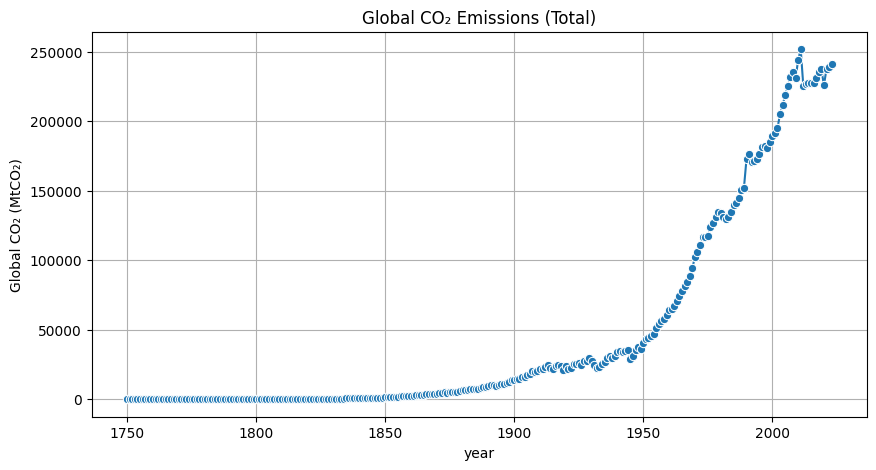

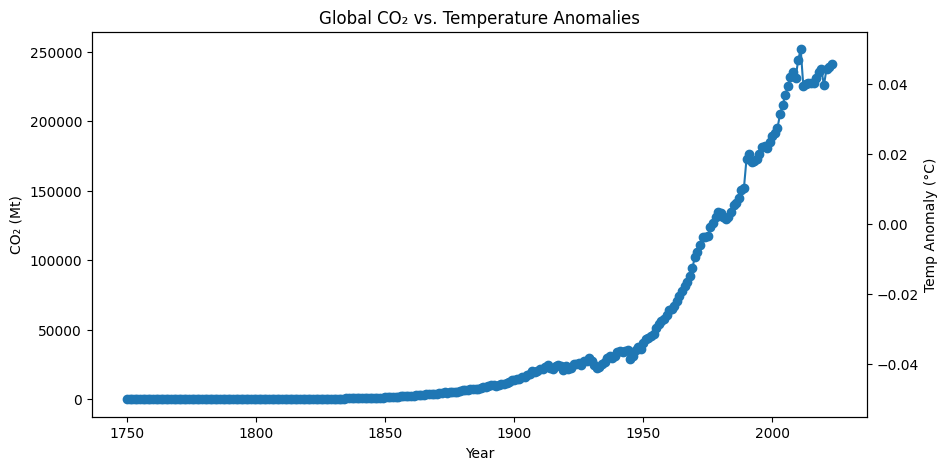

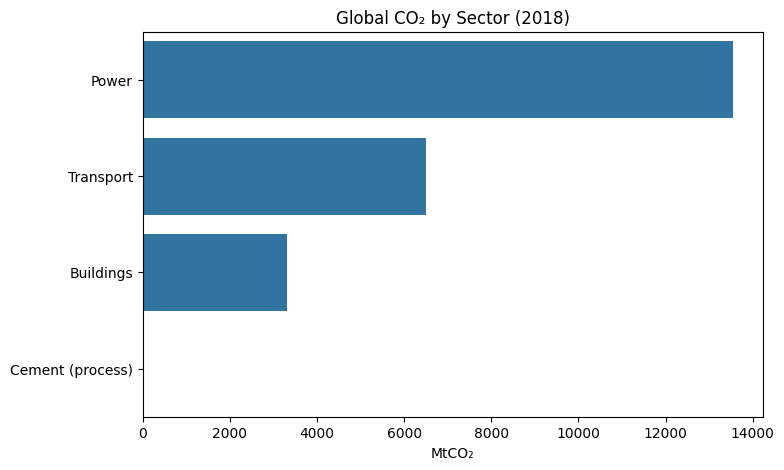

✅ Phase Two exploration complete. CSV summaries written: global_trend.csv and sector/temp summaries if available.


In [ ]:
# --- Phase Two · Merge & Baseline Exploration (master-panel wide-safe) ---
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path

BASE = Path('/content/drive/MyDrive/CO2')
PROC = BASE / 'processed'

master = pd.read_parquet(PROC / 'master_panel.parquet')
print(f"Master panel: {len(master):,} rows, {master['country'].nunique()} countries, years {master['year'].min()}–{master['year'].max()}")

# -----------------------------
# Helper: detect sector columns
# -----------------------------
KNOWN_SECTORS = {
    'Power','Transport','Buildings','Industry','Other','Cement (process)'
}
sector_cols = [c for c in master.columns if c in KNOWN_SECTORS]
if not sector_cols:
    # Fallback: guess sector columns as any non-core numeric columns
    core = {'iso_code','country','year','total_mtco2','temp_anomaly_degC'}
    sector_cols = [c for c in master.columns
                   if c not in core and master[c].dtype.kind in 'fi' and not c.startswith('_')]
print("Detected sector columns:", sector_cols)

# -----------------------------
# Quick sanity views
# -----------------------------
# Global total (from 'Global' row if present)
has_global = (master['country'] == 'Global').any()
if has_global and 'value_mtco2' in master.columns:
    # Some builds may carry an extra 'value_mtco2' from global table; prefer total_mtco2 when present
    global_series = master[master['country']=='Global']
    if 'total_mtco2' in global_series.columns and not global_series['total_mtco2'].isna().all():
        global_trend = global_series[['year','total_mtco2']].dropna().sort_values('year')
        ylab = 'Global CO₂ (MtCO₂)'
        yval = 'total_mtco2'
    else:
        global_trend = global_series[['year','value_mtco2']].dropna().sort_values('year')
        ylab = 'Global CO₂ (MtCO₂)'
        yval = 'value_mtco2'
else:
    # Build global total by summing countries (exclude 'Global' if present)
    tmp = master[master['country']!='Global'] if has_global else master
    if 'total_mtco2' in tmp.columns:
        global_trend = tmp.groupby('year')['total_mtco2'].sum().reset_index().sort_values('year')
        ylab = 'Global CO₂ (MtCO₂)'
        yval = 'total_mtco2'
    else:
        # As last resort, sum sectors
        tmp2 = tmp[['year'] + sector_cols].copy()
        global_trend = tmp2.groupby('year')[sector_cols].sum().sum(axis=1).reset_index(name='sum_mt')
        ylab = 'Global CO₂ (MtCO₂, sectors sum)'
        yval = 'sum_mt'

# Plot global CO₂ trend
plt.figure(figsize=(10,5))
sns.lineplot(data=global_trend, x='year', y=yval, marker='o')
plt.title("Global CO₂ Emissions (Total)")
plt.ylabel(ylab)
plt.grid(True)
plt.show()

# -----------------------------
# CO₂ vs Temperature (association)
# -----------------------------
if 'temp_anomaly_degC' in master.columns:
    temp_world = master[['year','temp_anomaly_degC']].groupby('year', as_index=False).mean().dropna()
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    ax1.plot(global_trend['year'], global_trend[yval], marker='o', label='Global CO₂ (Mt)')
    ax2.plot(temp_world['year'], temp_world['temp_anomaly_degC'], marker='o', label='Temp Anomaly (°C)')
    ax1.set_xlabel("Year")
    ax1.set_ylabel("CO₂ (Mt)")
    ax2.set_ylabel("Temp Anomaly (°C)")
    plt.title("Global CO₂ vs. Temperature Anomalies")
    plt.show()
else:
    print("ℹ️ No 'temp_anomaly_degC' column in master; skipping CO₂ vs Temp plot.")

# -----------------------------
# Sector leaderboard (latest year with sector data)
# -----------------------------
if sector_cols:
    # Choose the latest year where at least 3 sectors have data globally
    availability = master[['year'] + sector_cols].groupby('year')[sector_cols].apply(lambda df: df.notna().sum().sum())
    latest_year = availability[availability > 0].index.max()

    # Global sector totals at latest_year (sum across countries)
    sec_latest = (
        master[master['year']==latest_year][sector_cols]
        .sum(axis=0, skipna=True)
        .sort_values(ascending=False)
        .reset_index()
        .rename(columns={'index':'sector',0:'value_mtco2'})
    )

    plt.figure(figsize=(8,5))
    sns.barplot(data=sec_latest, x='value_mtco2', y='sector')
    plt.title(f"Global CO₂ by Sector ({latest_year})")
    plt.xlabel("MtCO₂")
    plt.ylabel("")
    plt.show()
else:
    print("ℹ️ No sector columns detected; skipping sector leaderboard.")

# -----------------------------
# Save summary tables
# -----------------------------
out_global = PROC / 'global_trend.csv'
global_trend.rename(columns={yval:'value_mtco2'}).to_csv(out_global, index=False)

if 'temp_world' in locals():
    temp_world.to_csv(PROC / 'global_temp.csv', index=False)

if sector_cols:
    sec_latest.to_csv(PROC / f'sector_leaderboard_{latest_year}.csv', index=False)

print("✅ Phase Two exploration complete. CSV summaries written:", out_global.name,
      "and sector/temp summaries if available.")

**📘 Phase Three — Forecasting & Projections**

**Description**

Here we’ll project CO₂ emissions into the near future (2025–2030) using three complementary methods:

	•	ARIMA (Auto-Regressive Integrated Moving Average) → robust for time series with trend.
	•	Prophet (Facebook/Meta’s library) → handles seasonality, trends, missing values well.
	•	Holt-Winters / Exponential Smoothing (LHTA) → captures level, trend, seasonality in a simpler form.

The goal is to:

	1.	Forecast global totals.
	2.	Forecast country-level totals (for a subset like India, US, China).
	3.	(Optional) Forecast sector-level emissions if data depth allows.
	4.	Save forecast tables (CSV) for 2025–2030 to feed your dashboard.

In [ ]:
# --- A) Install & imports ---
!pip -q install prophet pmdarima statsmodels matplotlib seaborn pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from datetime import datetime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 8.0 MB/s eta 0:00:00


In [ ]:
# --- B) Load & prepare series ---
BASE = Path('/content/drive/MyDrive/CO2/processed')
csv_path = BASE / 'global_trend.csv'  # produced in Phase Two

df = pd.read_csv(csv_path)
# Expect columns: year, value_mtco2
df = df.dropna(subset=['year', 'value_mtco2']).copy()
df['year'] = df['year'].astype(int)

# Make a datetime column for year-end (Prophet wants a 'ds' datetime)
df['ds'] = pd.to_datetime(df['year'].astype(str) + '-12-31')
df = df.sort_values('year')

print(df.tail(5))
print(f"Years {df['year'].min()}–{df['year'].max()}, n={len(df)}")

     year  value_mtco2         ds
269  2019   237289.378 2019-12-31
270  2020   225815.581 2020-12-31
271  2021   237662.364 2021-12-31
272  2022   238962.609 2022-12-31
273  2023   241116.668 2023-12-31
Years 1750–2023, n=274


/tmp/ipython-input-1766897993.py:7: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  series = df.set_index('ds')['value_mtco2'].asfreq('Y')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966

Best ARIMA order: (1, 1, 1) AIC: 5149.07889578399


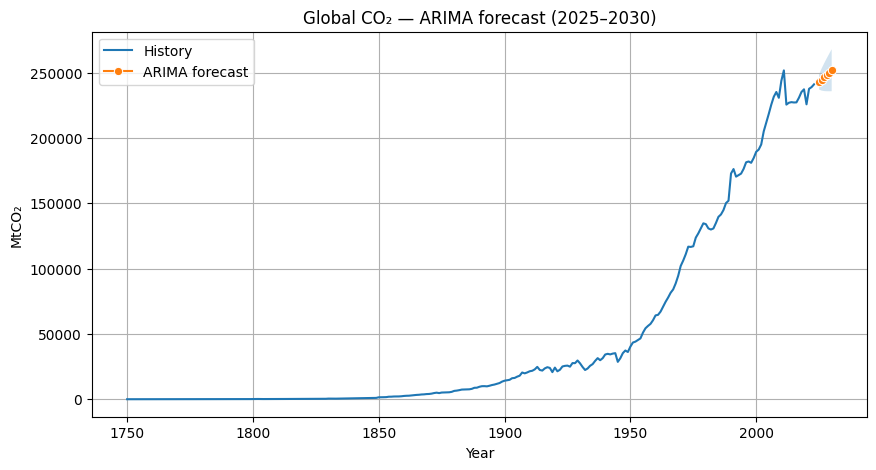

,model,year,yhat,yhat_lower,yhat_upper
0,ARIMA,2025,242943.955342,237107.400141,248780.510543
1,ARIMA,2026,244760.279372,236302.711477,253217.847266
2,ARIMA,2027,246565.705868,235957.451668,257173.960068
3,ARIMA,2028,248360.300212,235821.709731,260898.890693
4,ARIMA,2029,250144.127396,235801.589686,264486.665105


In [ ]:
# --- C-alt) ARIMA forecast (statsmodels, AIC grid search) ---
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

# df must already be loaded from Block B with columns: year, ds, value_mtco2
series = df.set_index('ds')['value_mtco2'].asfreq('Y')
series = series.interpolate()

# Small, reliable grid; expand if you want
pdq_grid = [(p,d,q) for p in range(0,3) for d in (0,1) for q in range(0,3)]

best_aic, best_order = np.inf, None
for order in pdq_grid:
    try:
        model = ARIMA(series, order=order).fit(method_kwargs={"warn_convergence":False})
        if model.aic < best_aic:
            best_aic, best_order = model.aic, order
    except Exception:
        continue

if best_order is None:
    raise RuntimeError("ARIMA search failed on all candidate orders.")

print("Best ARIMA order:", best_order, "AIC:", best_aic)
arima_model = ARIMA(series, order=best_order).fit()

# Forecast 2025–2030 inclusive
forecast_years = list(range(2025, 2031))
h = len(forecast_years)
fc = arima_model.get_forecast(steps=h)
ci = fc.conf_int(alpha=0.05)

arima_out = pd.DataFrame({
    'model': 'ARIMA',
    'year': forecast_years,
    'yhat': fc.predicted_mean.values,
    'yhat_lower': ci.iloc[:,0].values,
    'yhat_upper': ci.iloc[:,1].values
})

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(x=df['year'], y=df['value_mtco2'], label='History')
sns.lineplot(x=arima_out['year'], y=arima_out['yhat'], marker='o', label='ARIMA forecast')
plt.fill_between(arima_out['year'], arima_out['yhat_lower'], arima_out['yhat_upper'], alpha=0.2)
plt.title('Global CO₂ — ARIMA forecast (2025–2030)')
plt.xlabel('Year'); plt.ylabel('MtCO₂'); plt.grid(True); plt.show()

arima_out.head()

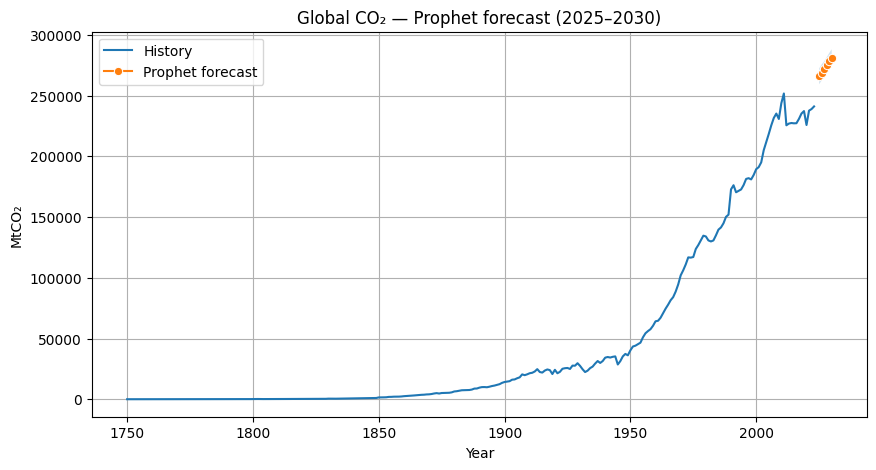

,model,year,yhat,yhat_lower,yhat_upper
0,Prophet,2025,265961.937668,259345.882518,272400.450763
1,Prophet,2026,269010.239956,262371.192667,275697.464277
2,Prophet,2027,272058.542244,265016.883739,278208.389460
3,Prophet,2028,275115.196044,268271.977196,281622.046344
4,Prophet,2029,278163.498332,271301.620506,285011.786427


In [ ]:
# --- D) Prophet forecast ---
from prophet import Prophet

# Prophet expects columns: ds (datetime), y (value)
df_prophet = df[['ds','value_mtco2']].rename(columns={'value_mtco2':'y'})

# Annual data; disable default weekly/yearly seasonality noise
m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
m.fit(df_prophet)

# Build a future dataframe for specific years 2025–2030
future = pd.DataFrame({'ds': pd.to_datetime(pd.Series([f'{y}-12-31' for y in range(2025, 2031)]))})
prop_fc = m.predict(future)

prop_out = pd.DataFrame({
    'model': 'Prophet',
    'year': prop_fc['ds'].dt.year,
    'yhat': prop_fc['yhat'],
    'yhat_lower': prop_fc['yhat_lower'],
    'yhat_upper': prop_fc['yhat_upper'],
})

# Plot
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=df['year'], y=df['value_mtco2'], label='History', ax=ax)
sns.lineplot(x=prop_out['year'], y=prop_out['yhat'], marker='o', label='Prophet forecast', ax=ax)
ax.fill_between(prop_out['year'], prop_out['yhat_lower'], prop_out['yhat_upper'], alpha=0.2)
ax.set_title('Global CO₂ — Prophet forecast (2025–2030)')
ax.set_xlabel('Year'); ax.set_ylabel('MtCO₂'); ax.grid(True)
plt.show()

prop_out.head()

/tmp/ipython-input-141871836.py:4: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = df.set_index('ds')['value_mtco2'].asfreq('Y')


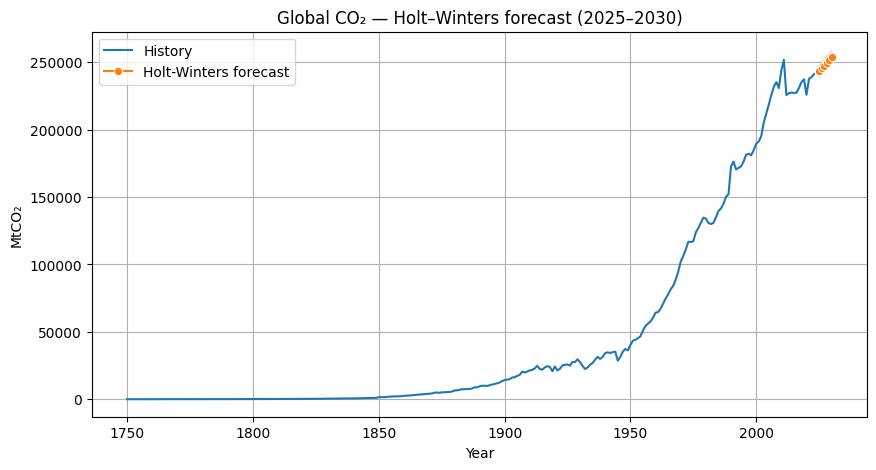

,model,year,yhat,yhat_lower,yhat_upper
0,HoltWinters,2025,243229.218335,237419.146448,249039.290222
1,HoltWinters,2026,245342.816699,239532.744812,251152.888586
2,HoltWinters,2027,247456.415063,241646.343176,253266.486950
3,HoltWinters,2028,249570.013427,243759.941540,255380.085314
4,HoltWinters,2029,251683.611791,245873.539904,257493.683678


In [ ]:
# --- E) Holt–Winters (Exponential Smoothing) ---
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ts = df.set_index('ds')['value_mtco2'].asfreq('Y')
ts = ts.interpolate()

# Annual data; no seasonality. Use additive trend (LHTA vibe).
hw = ExponentialSmoothing(ts, trend='add', seasonal=None, initialization_method='estimated')
hw_fit = hw.fit(optimized=True)

h = 6  # 2025..2030 inclusive
hw_fc = hw_fit.forecast(h)

hw_out = pd.DataFrame({
    'model': 'HoltWinters',
    'year': list(range(2025, 2031)),
    'yhat': hw_fc.values,
})
# Add simple symmetric intervals via residual std (not a true PI, but informative)
resid_std = np.std(hw_fit.resid)
hw_out['yhat_lower'] = hw_out['yhat'] - 1.96 * resid_std
hw_out['yhat_upper'] = hw_out['yhat'] + 1.96 * resid_std

# Plot
plt.figure(figsize=(10,5))
sns.lineplot(x=df['year'], y=df['value_mtco2'], label='History')
sns.lineplot(x=hw_out['year'], y=hw_out['yhat'], marker='o', label='Holt-Winters forecast')
plt.fill_between(hw_out['year'], hw_out['yhat_lower'], hw_out['yhat_upper'], alpha=0.2)
plt.title('Global CO₂ — Holt–Winters forecast (2025–2030)')
plt.xlabel('Year'); plt.ylabel('MtCO₂'); plt.grid(True); plt.show()

hw_out.head()

✅ wrote /content/drive/MyDrive/CO2/processed/forecasts_global.csv with 18 rows


,model,year,yhat,yhat_lower,yhat_upper
0,ARIMA,2025,242943.955342,237107.400141,248780.510543
1,ARIMA,2026,244760.279372,236302.711477,253217.847266
2,ARIMA,2027,246565.705868,235957.451668,257173.960068
3,ARIMA,2028,248360.300212,235821.709731,260898.890693
4,ARIMA,2029,250144.127396,235801.589686,264486.665105
5,ARIMA,2030,251917.252019,235850.418451,267984.085587
12,HoltWinters,2025,243229.218335,237419.146448,249039.290222
13,HoltWinters,2026,245342.816699,239532.744812,251152.888586
14,HoltWinters,2027,247456.415063,241646.343176,253266.486950
15,HoltWinters,2028,249570.013427,243759.941540,255380.085314


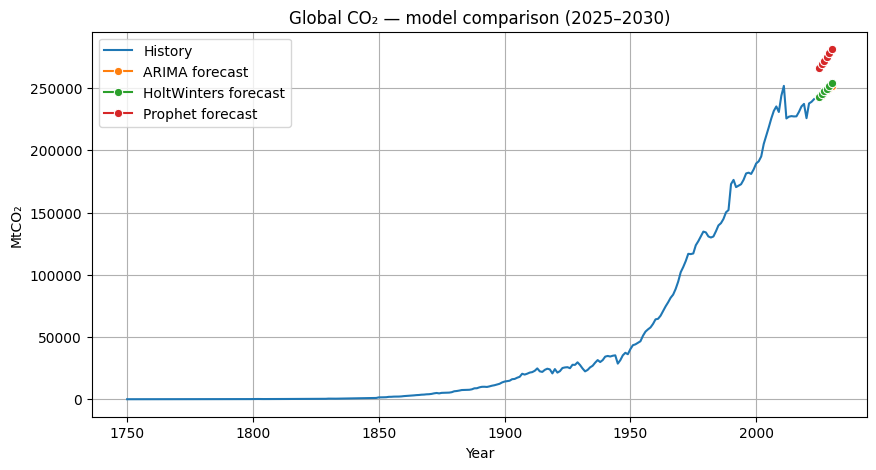

In [ ]:
# --- F) Combine & save ---
combined = pd.concat([arima_out, prop_out, hw_out], ignore_index=True)
combined = combined.sort_values(['model','year'])

out_path = BASE / 'forecasts_global.csv'
combined.to_csv(out_path, index=False)
print(f"✅ wrote {out_path} with {len(combined)} rows")
display(combined.head(12))

# Comparison plot
plt.figure(figsize=(10,5))
sns.lineplot(x=df['year'], y=df['value_mtco2'], label='History')
for mdl, sub in combined.groupby('model'):
    sns.lineplot(x=sub['year'], y=sub['yhat'], marker='o', label=f'{mdl} forecast')
plt.title('Global CO₂ — model comparison (2025–2030)')
plt.xlabel('Year'); plt.ylabel('MtCO₂'); plt.grid(True); plt.show()

📘 Phase 4a — Country-Level Forecasting

Description

This phase takes master_panel.parquet, extracts one country at a time, and runs ARIMA, Prophet, and Holt-Winters. We’ll do it for a shortlist of key countries (say India, United States, China to start). Output:

	•	Forecast plots per country (2025–2030).
	•	Forecast tables written to /processed/forecasts_country_<iso>.csv.

In [ ]:
# --- Phase 4a · Country-level setup ---
import pandas as pd
from pathlib import Path

BASE = Path('/content/drive/MyDrive/CO2')
PROC = BASE / 'processed'

master = pd.read_parquet(PROC / 'master_panel.parquet')

# pick focus countries by ISO or name
focus_countries = ['IND', 'USA', 'CHN']  # India, United States, China

print("Available ISO codes:", master['iso_code'].dropna().unique()[:20])  # sanity check

Available ISO codes: ['AFG' 'ALB' 'DZA' 'AND' 'AGO' 'AIA' 'ATA' 'ATG' 'ARG' 'ARM' 'ABW' 'AUS'
 'AUT' 'AZE' 'BHS' 'BHR' 'BGD' 'BRB' 'BLR' 'BEL']


In [ ]:
# --- Helper: run 3 models for one country ---
import matplotlib.pyplot as plt, seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def forecast_country(df, iso, horizon=(2025,2030)):
    sub = df[df['iso_code']==iso].dropna(subset=['total_mtco2'])
    if sub.empty:
        print(f"⚠️ No data for {iso}")
        return None

    sub = sub[['year','total_mtco2']].sort_values('year')
    sub['ds'] = pd.to_datetime(sub['year'].astype(str)+'-12-31')
    sub = sub.set_index('ds')

    # Align years
    last_hist_year = sub['year'].max()
    forecast_years = list(range(horizon[0], horizon[1]+1))
    h = len(forecast_years)

    results = []

    # --- ARIMA ---
    try:
        ts = sub['total_mtco2'].asfreq('Y').interpolate()
        best_aic, best_order = np.inf, None
        for order in [(p,d,q) for p in range(0,3) for d in (0,1) for q in range(0,3)]:
            try:
                model = ARIMA(ts, order=order).fit(method_kwargs={"warn_convergence":False})
                if model.aic < best_aic: best_aic, best_order = model.aic, order
            except: continue
        arima = ARIMA(ts, order=best_order).fit()
        fc = arima.get_forecast(steps=h)
        ci = fc.conf_int(alpha=0.05)
        out = pd.DataFrame({
            'model':'ARIMA','iso_code':iso,'year':forecast_years,
            'yhat':fc.predicted_mean.values,
            'yhat_lower':ci.iloc[:,0].values,
            'yhat_upper':ci.iloc[:,1].values
        })
        results.append(out)
    except Exception as e:
        print(f"ARIMA failed for {iso}: {e}")

    # --- Prophet ---
    try:
        df_prophet = sub.reset_index()[['ds','total_mtco2']].rename(columns={'total_mtco2':'y'})
        m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        m.fit(df_prophet)
        future = pd.DataFrame({'ds': pd.to_datetime(pd.Series([f'{y}-12-31' for y in forecast_years]))})
        fc = m.predict(future)
        out = pd.DataFrame({
            'model':'Prophet','iso_code':iso,'year':fc['ds'].dt.year,
            'yhat':fc['yhat'],'yhat_lower':fc['yhat_lower'],'yhat_upper':fc['yhat_upper']
        })
        results.append(out)
    except Exception as e:
        print(f"Prophet failed for {iso}: {e}")

    # --- Holt-Winters ---
    try:
        ts = sub['total_mtco2'].asfreq('Y').interpolate()
        hw = ExponentialSmoothing(ts, trend='add', seasonal=None, initialization_method='estimated').fit()
        fc = hw.forecast(h)
        resid_std = np.std(hw.resid)
        out = pd.DataFrame({
            'model':'HoltWinters','iso_code':iso,'year':forecast_years,
            'yhat':fc.values,
            'yhat_lower':fc.values - 1.96*resid_std,
            'yhat_upper':fc.values + 1.96*resid_std
        })
        results.append(out)
    except Exception as e:
        print(f"Holt-Winters failed for {iso}: {e}")

    # Combine
    if results:
        combined = pd.concat(results, ignore_index=True)
        # Save per-country
        out_path = PROC / f'forecasts_country_{iso}.csv'
        combined.to_csv(out_path, index=False)
        print(f"✅ Saved {out_path} ({len(combined)} rows)")

        # Plot
        plt.figure(figsize=(10,5))
        sns.lineplot(x=sub['year'], y=sub['total_mtco2'], label='History')
        for mdl, grp in combined.groupby('model'):
            sns.lineplot(x=grp['year'], y=grp['yhat'], marker='o', label=f'{mdl} forecast')
        plt.title(f"{iso} CO₂ forecast (2025–2030)")
        plt.xlabel("Year"); plt.ylabel("MtCO₂"); plt.grid(True); plt.show()
        return combined
    else:
        return None

ARIMA failed for IND: cannot reindex on an axis with duplicate labels


/tmp/ipython-input-3359347944.py:27: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = sub['total_mtco2'].asfreq('Y').interpolate()
/tmp/ipython-input-3359347944.py:64: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = sub['total_mtco2'].asfreq('Y').interpolate()


Holt-Winters failed for IND: cannot reindex on an axis with duplicate labels
✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_country_IND.csv (6 rows)


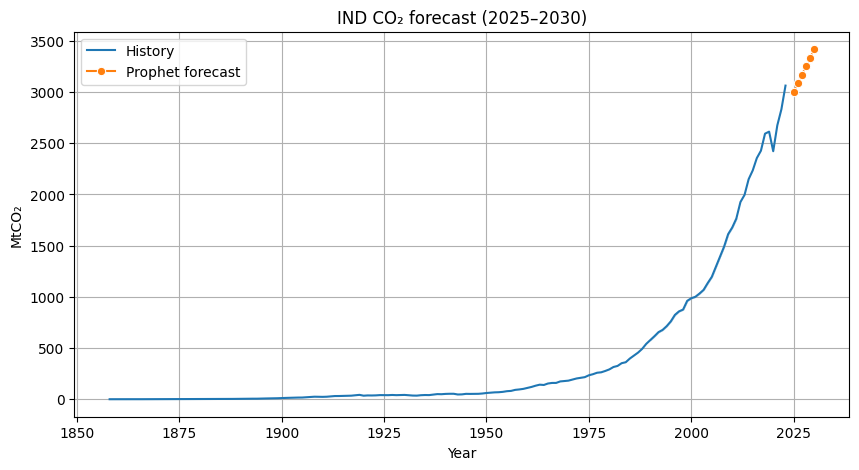

/tmp/ipython-input-3359347944.py:27: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = sub['total_mtco2'].asfreq('Y').interpolate()


ARIMA failed for USA: cannot reindex on an axis with duplicate labels


/tmp/ipython-input-3359347944.py:64: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = sub['total_mtco2'].asfreq('Y').interpolate()


Holt-Winters failed for USA: cannot reindex on an axis with duplicate labels
✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_country_USA.csv (6 rows)


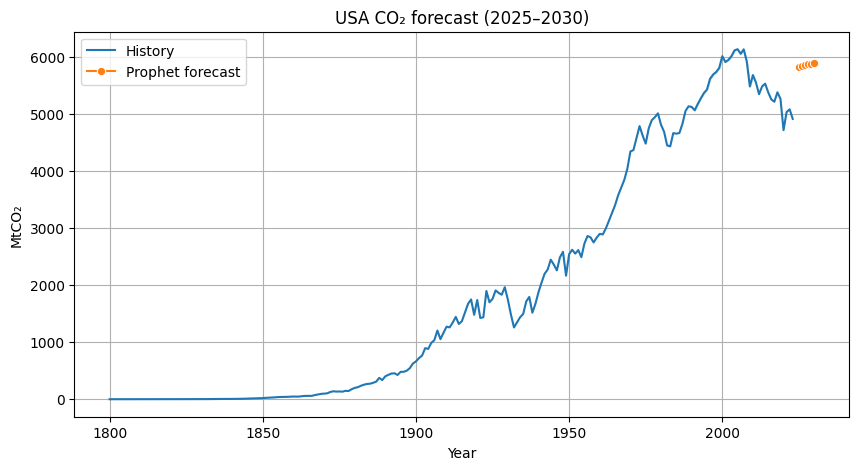

/tmp/ipython-input-3359347944.py:27: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = sub['total_mtco2'].asfreq('Y').interpolate()
/tmp/ipython-input-3359347944.py:64: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  ts = sub['total_mtco2'].asfreq('Y').interpolate()


ARIMA failed for CHN: cannot reindex on an axis with duplicate labels
Holt-Winters failed for CHN: cannot reindex on an axis with duplicate labels
✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_country_CHN.csv (6 rows)


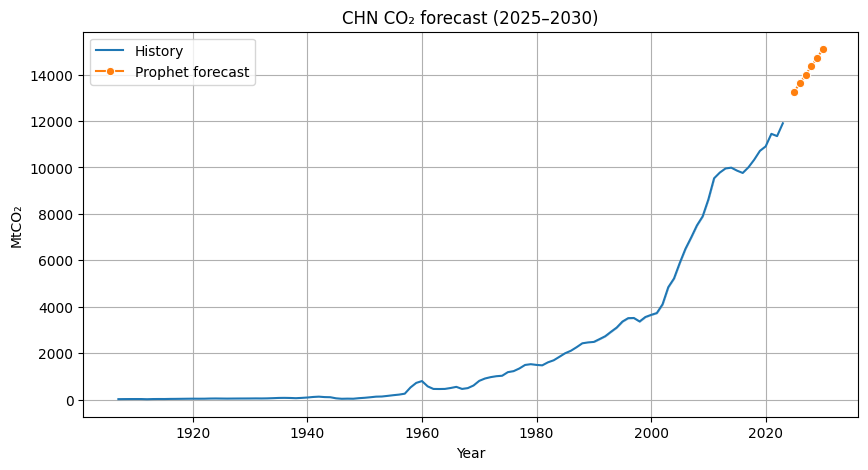

✅ Combined forecasts saved: /content/drive/MyDrive/CO2/processed/forecasts_country_all.csv


In [ ]:
# --- C) Forecast selected countries ---
all_country_forecasts = []
for iso in focus_countries:
    fc = forecast_country(master, iso)
    if fc is not None:
        all_country_forecasts.append(fc)

if all_country_forecasts:
    all_forecasts = pd.concat(all_country_forecasts, ignore_index=True)
    all_forecasts.to_csv(PROC / 'forecasts_country_all.csv', index=False)
    print(f"✅ Combined forecasts saved: {PROC / 'forecasts_country_all.csv'}")

**📘 Phase 4b — Sector-Level Forecasting**

**Description**

This phase takes the harmonized sectoral emissions data (EDGAR + Cement) from the master panel and projects them forward to 2030. The goal is to understand not just how much CO₂ countries emit overall, but which industries are driving that change.

*Steps performed in this phase:*

	1.	Detect sector columns in the master panel (Power, Transport, Industry, Buildings, Other, Cement).
	2.	Prepare sectoral time series for each focus country (e.g., India, USA, China) and for the global aggregate.
	3.	Run three forecast models (ARIMA, Prophet, Holt–Winters) for each sector series, covering 2025–2030.
	4.	Save per-country × sector forecasts (forecasts_sector_<ISO>_<sector>.csv).
	5.	Save global × sector forecasts (forecasts_sector_Global_<sector>.csv).
	6.	Produce plots for each forecasted series to visually compare history vs. future projections.
	7.	Generate a 2030 sector leaderboard at the global level (which sectors dominate global emissions).
	8.	Compute 2030 sector shares per focus country, showing the relative contribution of each sector within a country.

*Why this matters*

By disaggregating forecasts into sectors, we can answer:

	•	Which sectors are the main contributors to future CO₂ emissions?
	•	How does the sectoral mix differ between countries like India, the US, and China?
	•	What share of global emissions will Power vs. Transport vs. Cement hold in 2030?

These insights let you build a policy-relevant narrative in your paper and design dashboards that highlight both national trajectories and industry-specific interventions.
ries), so your notebook flows into policy modeling?

In [ ]:
# --- Phase 4b · Sector-level setup ---
import pandas as pd
from pathlib import Path

BASE = Path('/content/drive/MyDrive/CO2')
PROC = BASE / 'processed'
master = pd.read_parquet(PROC / 'master_panel.parquet')

# Known sector names used earlier; will also auto-detect numerics not in core
KNOWN_SECTORS = {'Power','Transport','Buildings','Industry','Other','Cement (process)'}
CORE = {'iso_code','country','year','total_mtco2','temp_anomaly_degC','value_mtco2'}

# Detect sector columns present in your master_panel
sector_cols = [c for c in master.columns if (c in KNOWN_SECTORS) or (c not in CORE and str(master[c].dtype)[0] in 'fi')]
sector_cols = sorted(sector_cols)
print("Detected sector columns:", sector_cols)

# Focus countries (change as you like)
focus_countries = ['IND','USA','CHN']

# Horizon
H_START, H_END = 2025, 2030

Detected sector columns: ['Buildings', 'Cement (process)', 'Other industrial combustion', 'Other sectors', 'Power', 'Transport']


In [ ]:
# --- Helpers for sector forecasting ---
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def make_sector_series(df, key_col, key_value, sector_col):
    """
    Extract an annual series (year, value) for a given country OR 'Global',
    for a given sector column (already in MtCO2).
    """
    if key_col == 'iso_code' and key_value == 'Global':
        sub = df[df['country']=='Global'][['year', sector_col]].rename(columns={sector_col:'value'})
    elif key_col == 'iso_code':
        sub = df[df['iso_code']==key_value][['year', sector_col]].rename(columns={sector_col:'value'})
    else:
        raise ValueError("key_col must be 'iso_code'")
    sub = sub.dropna(subset=['year','value']).sort_values('year')
    if sub.empty:
        return None
    sub['ds'] = pd.to_datetime(sub['year'].astype(int).astype(str) + '-12-31')
    return sub[['year','ds','value']]

def run_models_on_series(series_df, horizon_years, label):
    """
    series_df: columns [year, ds, value]
    Returns combined forecast df with columns [model, year, yhat, yhat_lower, yhat_upper, label]
    """
    if series_df is None or series_df.empty:
        return None

    # Prepare time series
    ts = series_df.set_index('ds')['value'].asfreq('Y').interpolate()
    forecast_years = list(range(horizon_years[0], horizon_years[1]+1))
    h = len(forecast_years)

    out_parts = []

    # --- ARIMA (grid by AIC) ---
    try:
        best_aic, best_order = np.inf, None
        for order in [(p,d,q) for p in range(0,3) for d in (0,1) for q in range(0,3)]:
            try:
                m = ARIMA(ts, order=order).fit(method_kwargs={"warn_convergence":False})
                if m.aic < best_aic: best_aic, best_order = m.aic, order
            except:
                continue
        m = ARIMA(ts, order=best_order).fit()
        fc = m.get_forecast(steps=h)
        ci = fc.conf_int(alpha=0.05)
        out_parts.append(pd.DataFrame({
            'model':'ARIMA','year':forecast_years,
            'yhat':fc.predicted_mean.values,
            'yhat_lower':ci.iloc[:,0].values,'yhat_upper':ci.iloc[:,1].values,
            'label':label
        }))
    except Exception as e:
        print(f"[{label}] ARIMA failed: {e}")

    # --- Prophet ---
    try:
        df_prophet = series_df[['ds','value']].rename(columns={'value':'y'})
        mp = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        mp.fit(df_prophet)
        future = pd.DataFrame({'ds': pd.to_datetime([f'{y}-12-31' for y in forecast_years])})
        pf = mp.predict(future)
        out_parts.append(pd.DataFrame({
            'model':'Prophet','year':pf['ds'].dt.year,
            'yhat':pf['yhat'],'yhat_lower':pf['yhat_lower'],'yhat_upper':pf['yhat_upper'],
            'label':label
        }))
    except Exception as e:
        print(f"[{label}] Prophet failed: {e}")

    # --- Holt–Winters ---
    try:
        hw = ExponentialSmoothing(ts, trend='add', seasonal=None, initialization_method='estimated').fit()
        fc = hw.forecast(h)
        resid_std = float(np.nanstd(hw.resid))
        out_parts.append(pd.DataFrame({
            'model':'HoltWinters','year':forecast_years,
            'yhat':fc.values,
            'yhat_lower':fc.values - 1.96*resid_std,
            'yhat_upper':fc.values + 1.96*resid_std,
            'label':label
        }))
    except Exception as e:
        print(f"[{label}] Holt-Winters failed: {e}")

    if out_parts:
        return pd.concat(out_parts, ignore_index=True)
    return None

def plot_sector_history_and_forecasts(series_df, combined_fc, title):
    plt.figure(figsize=(10,5))
    sns.lineplot(x=series_df['year'], y=series_df['value'], label='History')
    for mdl, grp in combined_fc.groupby('model'):
        sns.lineplot(x=grp['year'], y=grp['yhat'], marker='o', label=f'{mdl} forecast')
    plt.title(title); plt.xlabel("Year"); plt.ylabel("MtCO₂"); plt.grid(True); plt.show()

In [ ]:
# --- Patch: helpers v2 (dedupe years + 'YE' freq) ---
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

MIN_YEARS = 8  # require at least this many annual points after aggregation

def make_sector_series(df, key_col, key_value, sector_col, agg='sum'):
    """
    Build a clean annual series for a given country (iso_code) or 'Global' and sector column.
    - Dedup by year (sum by default; set agg='mean' if that's your preference).
    - Returns columns: [year, ds, value] with unique years only.
    """
    if key_col != 'iso_code':
        raise ValueError("key_col must be 'iso_code'")

    if key_value == 'Global':
        sub = df[df['country'] == 'Global'][['year', sector_col]].rename(columns={sector_col: 'value'})
        # If there's no explicit Global row, compute global = sum over countries
        if sub.empty:
            tmp = df[['year', sector_col]].copy()
            sub = tmp.groupby('year', as_index=False)[sector_col].sum().rename(columns={sector_col: 'value'})
    else:
        sub = df[df['iso_code'] == key_value][['year', sector_col]].rename(columns={sector_col: 'value'})

    # Keep numeric years only
    sub = sub.dropna(subset=['year']).copy()
    sub['year'] = pd.to_numeric(sub['year'], errors='coerce')
    sub = sub.dropna(subset=['year'])
    sub['year'] = sub['year'].astype(int)

    # Aggregate to one row per year to eliminate duplicates
    if agg == 'sum':
        sub = sub.groupby('year', as_index=False)['value'].sum()
    else:
        sub = sub.groupby('year', as_index=False)['value'].mean()

    # Create unique year-end datetime index
    sub['ds'] = pd.to_datetime(sub['year'].astype(str) + '-12-31')

    # Sort and drop any accidental duplicates on ds (shouldn't exist after groupby, but safe)
    sub = sub.sort_values('year').drop_duplicates(subset=['ds'])

    # Basic sufficiency check
    if len(sub) < MIN_YEARS:
        return None

    return sub[['year', 'ds', 'value']]

def run_models_on_series(series_df, horizon_years, label):
    """
    series_df: columns [year, ds, value] with unique years.
    Returns combined forecast df with columns [model, year, yhat, yhat_lower, yhat_upper, label]
    """
    if series_df is None or series_df.empty:
        return None

    # Ensure unique, sorted index and annual YE frequency
    ts = (series_df
          .set_index('ds')
          .sort_index()['value']
          .asfreq('YE'))  # 'YE' = year-end (replaces deprecated 'Y')
    # Fill small gaps gently (linear is fine for annual macro series)
    ts = ts.interpolate(limit_direction='both')

    forecast_years = list(range(horizon_years[0], horizon_years[1] + 1))
    h = len(forecast_years)

    out_parts = []

    # --- ARIMA (grid by AIC) ---
    try:
        best_aic, best_order = np.inf, None
        for order in [(p, d, q) for p in range(0, 3) for d in (0, 1) for q in range(0, 3)]:
            try:
                m = ARIMA(ts, order=order).fit(method_kwargs={"warn_convergence": False})
                if m.aic < best_aic:
                    best_aic, best_order = m.aic, order
            except Exception:
                continue
        m = ARIMA(ts, order=best_order).fit()
        fc = m.get_forecast(steps=h)
        ci = fc.conf_int(alpha=0.05)
        out_parts.append(pd.DataFrame({
            'model': 'ARIMA',
            'year': forecast_years,
            'yhat': fc.predicted_mean.values,
            'yhat_lower': ci.iloc[:, 0].values,
            'yhat_upper': ci.iloc[:, 1].values,
            'label': label
        }))
    except Exception as e:
        print(f"[{label}] ARIMA failed: {e}")

    # --- Prophet ---
    try:
        # Prophet needs unique ds; series_df already aggregated by year
        df_prophet = series_df[['ds', 'value']].drop_duplicates('ds').rename(columns={'value': 'y'})
        mp = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
        mp.fit(df_prophet)
        future = pd.DataFrame({'ds': pd.to_datetime([f'{y}-12-31' for y in forecast_years])})
        pf = mp.predict(future)
        out_parts.append(pd.DataFrame({
            'model': 'Prophet',
            'year': pf['ds'].dt.year,
            'yhat': pf['yhat'],
            'yhat_lower': pf['yhat_lower'],
            'yhat_upper': pf['yhat_upper'],
            'label': label
        }))
    except Exception as e:
        print(f"[{label}] Prophet failed: {e}")

    # --- Holt–Winters ---
    try:
        hw = ExponentialSmoothing(ts, trend='add', seasonal=None, initialization_method='estimated').fit()
        fc = hw.forecast(h)
        resid_std = float(np.nanstd(hw.resid))
        out_parts.append(pd.DataFrame({
            'model': 'HoltWinters',
            'year': forecast_years,
            'yhat': fc.values,
            'yhat_lower': fc.values - 1.96 * resid_std,
            'yhat_upper': fc.values + 1.96 * resid_std,
            'label': label
        }))
    except Exception as e:
        print(f"[{label}] Holt-Winters failed: {e}")

    if out_parts:
        return pd.concat(out_parts, ignore_index=True)
    return None

def plot_sector_history_and_forecasts(series_df, combined_fc, title):
    plt.figure(figsize=(10,5))
    sns.lineplot(x=series_df['year'], y=series_df['value'], label='History')
    for mdl, grp in combined_fc.groupby('model'):
        sns.lineplot(x=grp['year'], y=grp['yhat'], marker='o', label=f'{mdl} forecast')
    plt.title(title); plt.xlabel("Year"); plt.ylabel("MtCO₂"); plt.grid(True); plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_sector_Global_Buildings.csv (18 rows)


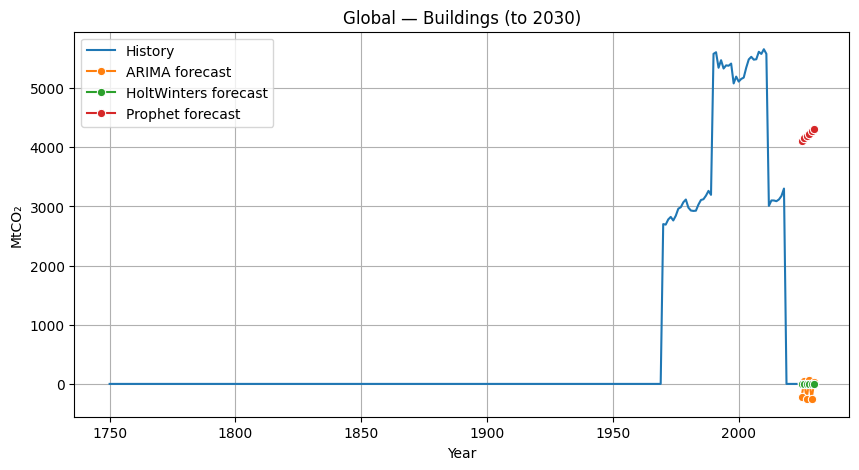

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/st

✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_sector_Global_Cement_(process).csv (18 rows)


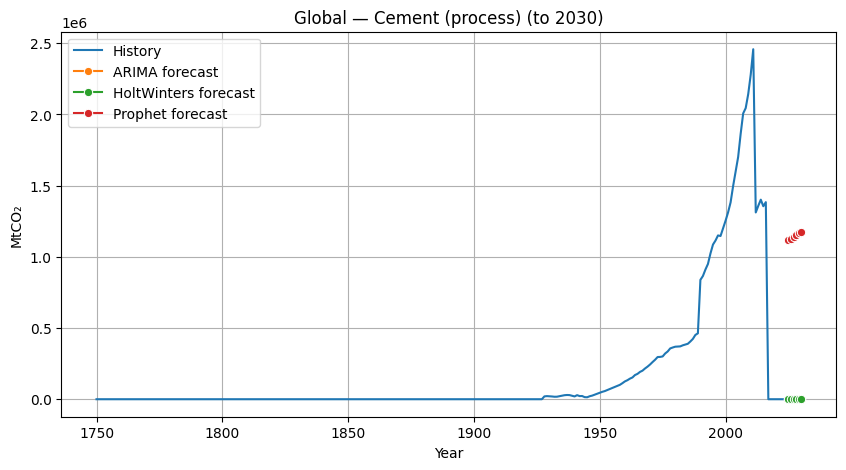

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_sector_Global_Other_industrial_combustion.csv (18 rows)


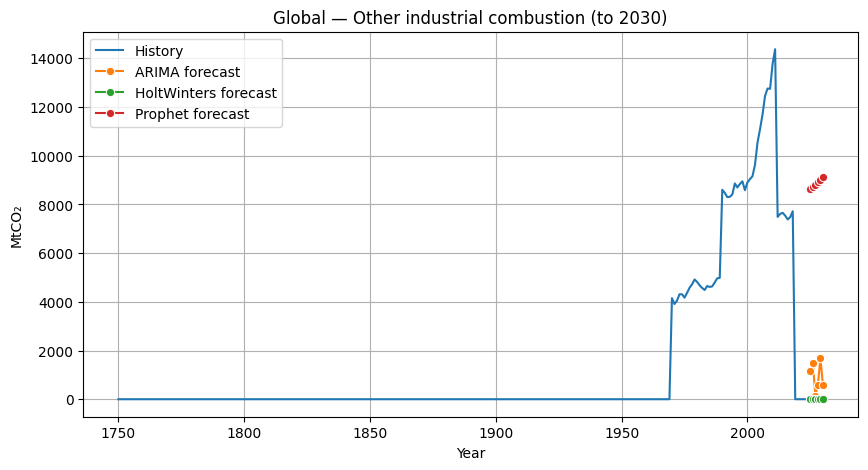

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/st

✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_sector_Global_Other_sectors.csv (18 rows)


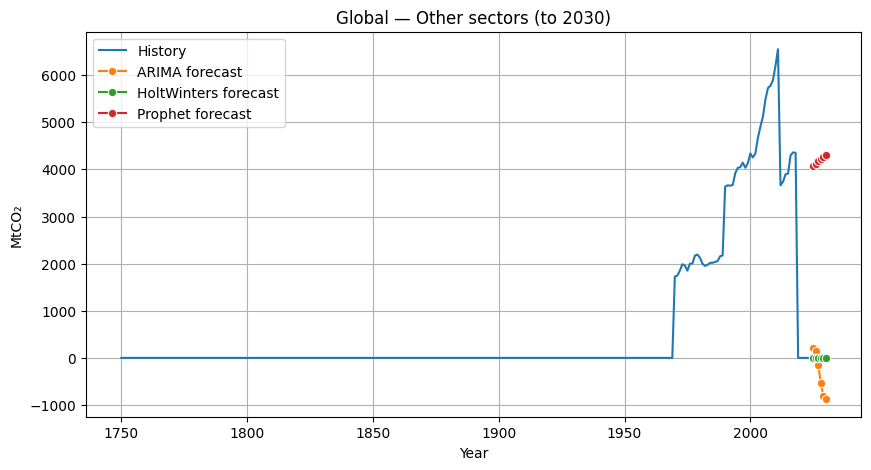

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_sector_Global_Power.csv (18 rows)


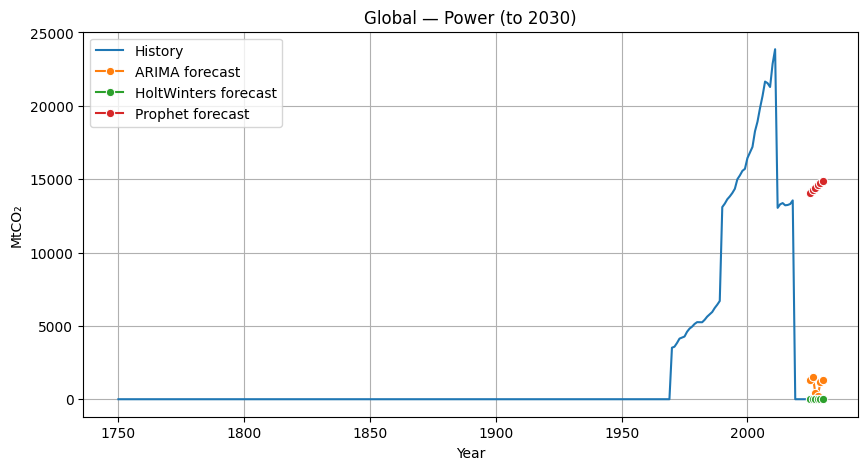

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


✅ Saved /content/drive/MyDrive/CO2/processed/forecasts_sector_Global_Transport.csv (18 rows)


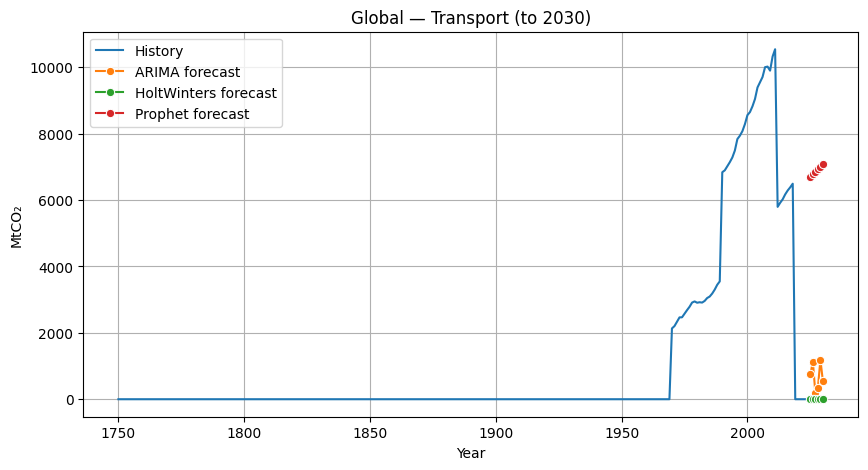

✅ Combined global×sector forecasts saved: /content/drive/MyDrive/CO2/processed/forecasts_sector_global_all.csv


In [ ]:
# --- Global × sector forecasts ---
all_global_sector_fc = []

for sector in sector_cols:
    s = make_sector_series(master, 'iso_code', 'Global', sector)
    if s is None or len(s) < 8:
        continue
    fc = run_models_on_series(s, (H_START,H_END), f"Global:{sector}")
    if fc is None:
        continue
    out = PROC / f'forecasts_sector_Global_{sector.replace(" ","_").replace("/","-")}.csv'
    fc.to_csv(out, index=False)
    print(f"✅ Saved {out} ({len(fc)} rows)")
    all_global_sector_fc.append(fc)
    plot_sector_history_and_forecasts(s, fc, f"Global — {sector} (to {H_END})")

if all_global_sector_fc:
    all_global_sector_fc = pd.concat(all_global_sector_fc, ignore_index=True)
    all_global_sector_fc.to_csv(PROC / 'forecasts_sector_global_all.csv', index=False)
    print(f"✅ Combined global×sector forecasts saved: {PROC / 'forecasts_sector_global_all.csv'}")
else:
    print("ℹ️ No global×sector forecasts generated.")

In [ ]:
# --- 2030 global sector leaderboard & shares (by ARIMA; swap to Prophet/HW if preferred) ---
import numpy as np

# Use ARIMA forecasts for 2030 by default
if 'all_global_sector_fc' in locals() and isinstance(all_global_sector_fc, pd.DataFrame):
    g30 = (all_global_sector_fc
           [ (all_global_sector_fc['model']=='ARIMA') & (all_global_sector_fc['year']==H_END) ]
           .copy())

    # Extract sector from 'label' = "Global:Sector Name"
    g30['sector'] = g30['label'].str.split(':', n=1).str[1]
    leaderboard_2030 = g30[['sector','yhat','yhat_lower','yhat_upper']].sort_values('yhat', ascending=False)

    # Sector shares
    total_2030 = leaderboard_2030['yhat'].sum()
    leaderboard_2030['share_%'] = 100.0 * leaderboard_2030['yhat'] / total_2030

    print("Global Sector Leaderboard — 2030 (ARIMA):")
    display(leaderboard_2030)

    leaderboard_2030.to_csv(PROC / f'sector_leaderboard_global_{H_END}.csv', index=False)
    print(f"✅ Saved {PROC / f'sector_leaderboard_global_{H_END}.csv'}")
else:
    print("ℹ️ No global sector forecasts found to build leaderboard.")

Global Sector Leaderboard — 2030 (ARIMA):


,sector,yhat,yhat_lower,yhat_upper,share_%
77,Power,1305.628682,-4250.588471,6861.845835,81.703960
41,Other industrial combustion,599.938420,-2832.608822,4032.485662,37.543097
95,Transport,535.897523,-2269.821917,3341.616964,33.535530
5,Buildings,33.497298,-1584.417101,1651.411697,2.096202
23,Cement (process),0.000000,-547118.672829,547118.672829,0.000000
59,Other sectors,-876.962650,-2221.964777,468.039476,-54.878789


✅ Saved /content/drive/MyDrive/CO2/processed/sector_leaderboard_global_2030.csv


In [ ]:
import os
import numpy as np
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Optional imports
try:
    from prophet import Prophet
    HAS_PROPHET = True
except ImportError:
    HAS_PROPHET = False

try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
    from sklearn.preprocessing import MinMaxScaler
    HAS_LSTM = True
except ImportError:
    HAS_LSTM = False

# =========================
# CONFIG
# =========================

# Your actual path from the Drive tree
INPUT_CSV_PATH = "./drive/MyDrive/CO2/raw/cement/cement-emissions.csv"
OUTPUT_CSV_PATH = "./drive/MyDrive/CO2/processed/cement_emission_filled_forecast.csv"

TARGET_END_YEAR = 2024          # extend horizon to match unified panel
MIN_YEARS_REQUIRED = 8          # min history per country to trust models
EPS = 1e-6                      # avoid exact 0 when representing model-based values


# =========================
# LOAD & TIDY (WIDE -> LONG)
# =========================

def load_cement_data() -> pd.DataFrame:
    if not os.path.exists(INPUT_CSV_PATH):
        raise FileNotFoundError(
            f"cement-emissions.csv not found at:\n{INPUT_CSV_PATH}\n"
            "Mount Drive and verify the path."
        )

    df_wide = pd.read_csv(INPUT_CSV_PATH)

    # Expect 'Year' + many country columns
    if "Year" not in df_wide.columns:
        # allow lowercase fallback
        year_col = None
        for c in df_wide.columns:
            if c.lower() == "year":
                year_col = c
                break
        if year_col is None:
            raise ValueError("No 'Year' column found in cement-emissions.csv")
        df_wide = df_wide.rename(columns={year_col: "Year"})

    # Melt into long format: country, year, cement_emission
    id_col = "Year"
    value_cols = [c for c in df_wide.columns if c != id_col]

    df_long = df_wide.melt(
        id_vars=[id_col],
        value_vars=value_cols,
        var_name="country",
        value_name="cement_emission",
    )

    # Clean types
    df_long = df_long.rename(columns={"Year": "year"})
    df_long["year"] = df_long["year"].astype(int)

    # Keep rows where we actually have data (NaN means no data for that country-year)
    df_long = df_long.dropna(subset=["cement_emission"])

    # DO NOT treat 0 as missing — those are legit early-year zeros
    df_long = df_long.sort_values(["country", "year"]).reset_index(drop=True)

    return df_long


# =========================
# MODEL HELPERS
# =========================

def forecast_arima(series: pd.Series, horizon: int) -> np.ndarray:
    if horizon <= 0:
        return np.array([])
    try:
        model = ARIMA(series, order=(1, 1, 1))
        fitted = model.fit()
        fc = fitted.forecast(steps=horizon)
        return np.maximum(fc.values, 0.0)
    except Exception:
        return np.full(horizon, np.nan)


def forecast_holt_winters(series: pd.Series, horizon: int) -> np.ndarray:
    if horizon <= 0:
        return np.array([])
    try:
        model = ExponentialSmoothing(series, trend="add", seasonal=None)
        fitted = model.fit(optimized=True)
        fc = fitted.forecast(horizon)
        return np.maximum(fc.values, 0.0)
    except Exception:
        return np.full(horizon, np.nan)


def forecast_prophet(series: pd.Series, start_year: int, horizon: int) -> np.ndarray:
    if not HAS_PROPHET or horizon <= 0 or len(series) < 3:
        return np.full(horizon, np.nan)
    try:
        years = [start_year + i for i in range(len(series))]
        df_p = pd.DataFrame({
            "ds": pd.to_datetime(years, format="%Y"),
            "y": series.values
        })
        m = Prophet(
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
        )
        m.fit(df_p)
        future = m.make_future_dataframe(periods=horizon, freq="Y")
        fc = m.predict(future)
        tail = fc.tail(horizon)["yhat"].values
        return np.maximum(tail, 0.0)
    except Exception:
        return np.full(horizon, np.nan)


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(32, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(loss="mse", optimizer="adam")
    return model


def forecast_lstm(series: pd.Series, horizon: int, look_back: int = 3) -> np.ndarray:
    if not HAS_LSTM or horizon <= 0 or len(series) <= look_back + 2:
        return np.full(horizon, np.nan)
    try:
        values = series.values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)

        X, y = [], []
        for i in range(len(scaled) - look_back):
            X.append(scaled[i:i+look_back, 0])
            y.append(scaled[i+look_back, 0])
        X, y = np.array(X), np.array(y)
        if len(X) == 0:
            return np.full(horizon, np.nan)

        X = X.reshape((X.shape[0], X.shape[1], 1))

        model = build_lstm_model((look_back, 1))
        model.fit(X, y, epochs=100, batch_size=8, verbose=0)

        last_seq = scaled[-look_back:, 0].tolist()
        preds_scaled = []
        for _ in range(horizon):
            x_input = np.array(last_seq[-look_back:]).reshape((1, look_back, 1))
            yhat = model.predict(x_input, verbose=0)[0, 0]
            preds_scaled.append(yhat)
            last_seq.append(yhat)

        preds_scaled = np.array(preds_scaled).reshape(-1, 1)
        preds = scaler.inverse_transform(preds_scaled).flatten()
        return np.maximum(preds, 0.0)
    except Exception:
        return np.full(horizon, np.nan)


# =========================
# COUNTRY-LEVEL PIPELINE
# =========================

def generate_country_forecasts(country_df: pd.DataFrame) -> pd.DataFrame:
    """
    country_df: rows for a single country with columns [country, year, cement_emission]
    - No zero-as-missing nonsense.
    - Forecast beyond last actual year to TARGET_END_YEAR.
    - final_yhat = actual (cleaned) within history, ensemble outside.
    """
    country = country_df["country"].iloc[0]
    country_df = country_df.sort_values("year")

    start_year = country_df["year"].min()
    last_actual_year = country_df["year"].max()

    # Full year range
    full_years = np.arange(start_year, TARGET_END_YEAR + 1)
    merged = pd.DataFrame({"country": country, "year": full_years})

    # Merge existing emissions; only NaN means no data
    merged = merged.merge(
        country_df[["year", "cement_emission"]],
        on="year",
        how="left"
    )

    # Fill internal gaps *only* across NaNs (keep true zeros)
    merged["cement_emission"] = merged["cement_emission"].interpolate("linear")
    merged["cement_emission"] = merged["cement_emission"].ffill().bfill()

    if merged["cement_emission"].isna().all():
        merged["yhat_arima"] = np.nan
        merged["yhat_hw"] = np.nan
        merged["yhat_prophet"] = np.nan
        merged["yhat_lstm"] = np.nan
        merged["final_yhat"] = np.nan
        return merged

    # Training: only up to last_actual_year
    train_mask = merged["year"] <= last_actual_year
    train_series = merged.loc[train_mask, "cement_emission"]

    # If too short, use cleaned series as final_yhat
    if len(train_series.dropna()) < MIN_YEARS_REQUIRED:
        merged["yhat_arima"] = np.nan
        merged["yhat_hw"] = np.nan
        merged["yhat_prophet"] = np.nan
        merged["yhat_lstm"] = np.nan
        merged["final_yhat"] = merged["cement_emission"].fillna(EPS)
        return merged

    # Forecast horizon (post-2016 typically)
    future_mask = merged["year"] > last_actual_year
    forecast_years = merged.loc[future_mask, "year"].values
    horizon = len(forecast_years)

    merged["yhat_arima"] = np.nan
    merged["yhat_hw"] = np.nan
    merged["yhat_prophet"] = np.nan
    merged["yhat_lstm"] = np.nan

    if horizon > 0:
        merged.loc[future_mask, "yhat_arima"] = forecast_arima(train_series, horizon)
        merged.loc[future_mask, "yhat_hw"] = forecast_holt_winters(train_series, horizon)
        merged.loc[future_mask, "yhat_prophet"] = forecast_prophet(train_series, start_year, horizon)
        merged.loc[future_mask, "yhat_lstm"] = forecast_lstm(train_series, horizon)

    # Build final_yhat
    last_known = (
        merged.loc[merged["year"] <= last_actual_year, "cement_emission"]
        .dropna()
        .iloc[-1]
    )

    final_vals = []
    for _, row in merged.iterrows():
        year = row["year"]
        if year <= last_actual_year:
            val = row["cement_emission"]
        else:
            preds = [
                row["yhat_arima"],
                row["yhat_hw"],
                row["yhat_prophet"],
                row["yhat_lstm"],
            ]
            preds = [p for p in preds if not pd.isna(p)]
            if preds:
                val = float(np.mean(preds))
            else:
                val = last_known

        # Don’t allow negative; if model glitches to NaN/neg, use tiny positive
        if pd.isna(val) or val < 0:
            val = EPS

        final_vals.append(val)

    merged["final_yhat"] = final_vals

    return merged


# =========================
# GLOBAL COEFFICIENTS
# =========================

def add_global_coefficients(df: pd.DataFrame) -> pd.DataFrame:
    """
    cement_emission_harmonized = final_yhat
    global_mean = mean(final_yhat) across countries for that year
    cement_emission_coeff_global = final_yhat / global_mean
    """
    df["cement_emission_harmonized"] = df["final_yhat"]

    global_mean = (
        df.groupby("year")["cement_emission_harmonized"]
        .mean()
        .replace(0, EPS)
        .rename("global_mean")
    )

    df = df.merge(global_mean, on="year", how="left")
    df["cement_emission_coeff_global"] = (
        df["cement_emission_harmonized"] / df["global_mean"]
    )

    return df


# =========================
# MAIN
# =========================

def main():
    df_raw = load_cement_data()

    country_results = []
    for country, group in df_raw.groupby("country"):
        country_results.append(generate_country_forecasts(group))

    df_all = pd.concat(country_results, ignore_index=True)
    df_all = add_global_coefficients(df_all)

    cols = [
        "country",
        "year",
        "cement_emission",
        "yhat_arima",
        "yhat_hw",
        "yhat_prophet",
        "yhat_lstm",
        "final_yhat",
        "cement_emission_harmonized",
        "global_mean",
        "cement_emission_coeff_global",
    ]
    df_all = df_all[cols]

    os.makedirs(os.path.dirname(OUTPUT_CSV_PATH), exist_ok=True)
    df_all.to_csv(OUTPUT_CSV_PATH, index=False)
    print(f"[OK] Saved filled + forecasted cement emissions to:\n{OUTPUT_CSV_PATH}")


if __name__ == "__main__":
    main()

/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/prop

Phase 4c — Scenario Analysis (Conservative / Central / Aggressive)

What this does

	•	Takes your existing global and (if present) country forecasts.
	•	Applies simple policy-style multipliers per year to produce Conservative / Central / Aggressive scenarios for 2025–2030.
	•	Writes clean CSVs for your dashboard/paper.

Works even if you only have global forecasts. If forecasts_country_all.csv exists, it will generate country scenarios too.

⸻

Cell 1 — Description (put this in a Markdown cell)

Description — Phase 4c: Scenario Analysis

We transform baseline forecasts into three narrative scenarios:

	•	Conservative: slower mitigation (−0.5%/yr improvement from 2025).
	•	Central: moderate mitigation (−1.5%/yr).
	•	Aggressive: faster mitigation (−3.0%/yr).

For each year y in 2025–2030 we apply a multiplicative factor to the baseline forecast \hat{E}_y:
E^{(scenario)}_y = \hat{E}_y \times (1 - r)^{(y-2024)}, where r is the annual reduction rate.

We apply the same factor to uncertainty bounds to keep intervals consistent.

Outputs:

	•	forecasts_global_scenarios.csv
	•	forecasts_country_scenarios.csv (only if country forecasts available)

In [ ]:
# --- Phase 4c · Scenario Analysis (totals) ---
import pandas as pd
import numpy as np
from pathlib import Path

BASE = Path('/content/drive/MyDrive/CO2')
PROC = BASE / 'processed'

# Load baseline forecasts
global_fc_path = PROC / 'forecasts_global.csv'
country_fc_path = PROC / 'forecasts_country_all.csv'  # may not exist

assert global_fc_path.exists(), "forecasts_global.csv not found. Run Phase 3 combine cell."

global_fc = pd.read_csv(global_fc_path)
global_fc = global_fc[['model','year','yhat','yhat_lower','yhat_upper']]

# Optional country forecasts
if country_fc_path.exists():
    country_fc = pd.read_csv(country_fc_path)
    # Expect columns: model, iso_code, year, yhat, yhat_lower, yhat_upper
    have_country = {'model','iso_code','year','yhat'}.issubset(country_fc.columns)
else:
    country_fc = None
    have_country = False

# Scenario definitions (annual reduction rates after 2024)
SCENARIOS = {
    'Conservative': 0.005,   # 0.5% per year
    'Central':      0.015,   # 1.5% per year
    'Aggressive':   0.030    # 3.0% per year
}

def apply_scenarios(df, year_col='year', y_col='yhat', lo_col='yhat_lower', hi_col='yhat_upper', extra_cols=None):
    out = []
    for scen, rate in SCENARIOS.items():
        tmp = df.copy()
        # years offset (2025 = 1, ..., 2030 = 6)
        k = (tmp[year_col] - 2024).clip(lower=0)
        factor = np.power(1 - rate, k)

        tmp['scenario'] = scen
        tmp[y_col]  = tmp[y_col]  * factor
        if lo_col in tmp.columns: tmp[lo_col] = tmp[lo_col] * factor
        if hi_col in tmp.columns: tmp[hi_col] = tmp[hi_col] * factor

        keep = ['scenario', year_col, y_col]
        if lo_col in tmp.columns: keep.append(lo_col)
        if hi_col in tmp.columns: keep.append(hi_col)
        if extra_cols: keep += [c for c in extra_cols if c in tmp.columns]
        out.append(tmp[keep])
    return pd.concat(out, ignore_index=True)

# Global scenarios (we keep each model's scenario; your dashboard can choose)
global_scen = apply_scenarios(global_fc, extra_cols=['model'])
global_scen.to_csv(PROC / 'forecasts_global_scenarios.csv', index=False)
print(f"✅ Saved {PROC / 'forecasts_global_scenarios.csv'}  ({len(global_scen)} rows)")

# Country scenarios (if available)
if have_country:
    # Keep only needed columns
    cf = country_fc[['model','iso_code','year','yhat','yhat_lower','yhat_upper']].copy()
    country_scen = apply_scenarios(cf, extra_cols=['model','iso_code'])
    country_scen.to_csv(PROC / 'forecasts_country_scenarios.csv', index=False)
    print(f"✅ Saved {PROC / 'forecasts_country_scenarios.csv'}  ({len(country_scen)} rows)")
else:
    print("ℹ️ No country forecasts found; skipping country scenarios.")

In [ ]:
# --- Optional: quick plots to sanity-check scenarios (global, using ARIMA only) ---
import matplotlib.pyplot as plt
import seaborn as sns

g = global_scen[global_scen['model']=='ARIMA']
plt.figure(figsize=(10,5))
for scen, grp in g.groupby('scenario'):
    sns.lineplot(x=grp['year'], y=grp['yhat'], marker='o', label=scen)
plt.title('Global CO₂ Scenarios (ARIMA baseline)')
plt.xlabel('Year'); plt.ylabel('MtCO₂'); plt.grid(True); plt.show()


In [ ]:
#@title OPTIONAL · Temperature enrichment via Kaggle (non-destructive) { display-mode: "form" }
# This cell:
# - downloads the Kaggle dataset via KaggleHub (current API)
# - tidies to (country, year, temp_anomaly_degC)
# - writes processed/temp_kaggle.parquet
# It DOES NOT modify master_panel.parquet or earlier phases.

# Install once per runtime (quiet)
!pip -q install --upgrade kagglehub

import pandas as pd, numpy as np, re
from pathlib import Path
import kagglehub

BASE = Path('/content/drive/MyDrive/CO2')
PROC = BASE / 'processed'
PROC.mkdir(parents=True, exist_ok=True)

# --- 1) Download dataset folder (returns local path) ---
ds_path = kagglehub.dataset_download("mdazizulkabirlovlu/all-countries-temperature-statistics-1970-2021")
print("📦 Kaggle dataset cached at:", ds_path)

# --- 2) Load the CSV from that folder ---
csv_path = Path(ds_path) / "all countries global temperature.csv"  # exact filename
assert csv_path.exists(), f"CSV not found at {csv_path}"
df_kaggle = pd.read_csv(csv_path)
df_kaggle.columns = [str(c).strip() for c in df_kaggle.columns]
print("✅ Loaded CSV:", csv_path.name, "shape:", df_kaggle.shape)

# --- 3) Tidy: wide years → long (country, year, temp_anomaly_degC) ---
country_col = next((c for c in df_kaggle.columns if c.lower() in ('country name','country','name','country_name')), None)
if not country_col:
    raise ValueError("Couldn't find a 'Country Name' column in the Kaggle CSV.")

year_cols = [c for c in df_kaggle.columns if re.fullmatch(r'\d{4}', str(c))]
if not year_cols:
    raise ValueError("No 4-digit year columns found in Kaggle CSV.")

long = (df_kaggle
        .melt(id_vars=[country_col], value_vars=year_cols,
              var_name='year', value_name='temp_anomaly_degC')
        .rename(columns={country_col:'country'}))

# Coerce year + clean numeric values
long['year'] = pd.to_numeric(long['year'], errors='coerce').astype('Int64')

def _to_float(x):
    if pd.isna(x): return np.nan
    if isinstance(x, str):
        t = x.strip()
        if t in ('', '.', '..', '—', '-', 'NA', 'NaN', 'nan'): return np.nan
        t = t.replace(',', '')
        try: return float(t)
        except: return np.nan
    try: return float(x)
    except: return np.nan

long['temp_anomaly_degC'] = long['temp_anomaly_degC'].map(_to_float)
long = long[long['year'].notna()].copy()

# --- 4) Save tidy parquet (country, year, temp_anomaly_degC) ---
outp = PROC / 'temp_kaggle.parquet'
long[['country','year','temp_anomaly_degC']].to_parquet(outp, index=False)
print(f"🎯 Saved: {outp}  ({len(long):,} rows, {int(long['year'].min())}–{int(long['year'].max())})")

In [ ]:
import sys, subprocess, importlib
def _pip(pkg_spec):
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg_spec], check=False, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

# Prophet
try:
    import prophet  # type: ignore
except Exception:
    _pip("prophet==1.1.5")
    _pip("pystan==2.19.1.1")
# Statsmodels (ETS, Granger)
try:
    import statsmodels  # type: ignore
except Exception:
    _pip("statsmodels>=0.13.5")

# ==== Imports ====
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import grangercausalitytests

# ==== Paths ====
BASE = Path("/content/drive/MyDrive/CO2")
PROC = BASE / "processed"
MASTER_PATH = PROC / "master_panel.parquet"
KAGGLE_TEMP_PATH = PROC / "temp_kaggle.parquet"  # from your Kaggle cell
OUT_COUPLING   = PROC / "coupling_summary.csv"
OUT_T_FORECAST = PROC / "temperature_forecasts_country.csv"

assert MASTER_PATH.exists(), "master_panel.parquet not found. Run Phases 1–2 first."
PROC.mkdir(parents=True, exist_ok=True)

# ==== Load ====
master = pd.read_parquet(MASTER_PATH)
kaggle_temp = pd.read_parquet(KAGGLE_TEMP_PATH) if KAGGLE_TEMP_PATH.exists() else None

# ---- Helpers ----
def _to_float(s):
    return pd.to_numeric(s, errors="coerce").astype(float)

def temp_series_for_country(master_df, country, y0=None, y1=None, kaggle_df=None):
    """Return tidy temp series with source label; prefers master, falls back to Kaggle. Dtype-safe."""
    if "temp_anomaly_degC" in master_df.columns:
        base = (master_df.loc[master_df["country"]==country, ["year","temp_anomaly_degC"]]
                          .dropna()
                          .rename(columns={"temp_anomaly_degC":"t_master"}))
    else:
        base = pd.DataFrame(columns=["year","t_master"])

    if kaggle_df is not None:
        k = (kaggle_df.loc[kaggle_df["country"]==country, ["year","temp_anomaly_degC"]]
                        .rename(columns={"temp_anomaly_degC":"t_kaggle"}))
    else:
        k = pd.DataFrame(columns=["year","t_kaggle"])

    ts = pd.merge(base, k, on="year", how="outer").sort_values("year")
    ts["t_master"] = _to_float(ts.get("t_master"))
    ts["t_kaggle"] = _to_float(ts.get("t_kaggle"))
    ts["temp_anomaly_degC"] = ts["t_master"].where(ts["t_master"].notna(), ts["t_kaggle"])
    ts["source"] = None
    ts.loc[ts["t_kaggle"].notna(), "source"] = "kaggle"
    ts.loc[ts["t_master"].notna(), "source"] = "master"

    ts = ts[["year","temp_anomaly_degC","source"]].dropna(subset=["year"]).copy()
    ts["year"] = _to_float(ts["year"]).astype(int)
    if y0 is not None and y1 is not None:
        ts = ts[(ts["year"]>=y0) & (ts["year"]<=y1)]
    return ts

def co2_series_for_country(master_df, country, y0=None, y1=None):
    s = (master_df.loc[master_df["country"]==country, ["year","total_mtco2"]]
                   .dropna(subset=["year","total_mtco2"])
                   .rename(columns={"total_mtco2":"co2_mt"})
                   .sort_values("year"))
    s["year"] = _to_float(s["year"]).astype(int)
    s["co2_mt"] = _to_float(s["co2_mt"])
    if y0 is not None and y1 is not None:
        s = s[(s["year"]>=y0) & (s["year"]<=y1)]
    return s

def align_country(master_df, country, end_year=2021, kaggle_df=None):
    """Outer align CO₂ & Temp by year, then trim to <= end_year and drop rows with NaNs."""
    c = co2_series_for_country(master_df, country)
    t = temp_series_for_country(master_df, country, kaggle_df=kaggle_df)
    df = pd.merge(c, t, on="year", how="inner")
    df = df[df["year"]<=int(end_year)].dropna(subset=["co2_mt","temp_anomaly_degC"]).sort_values("year")
    return df

def lag_corr(x: pd.Series, y: pd.Series, maxlag: int = 5):
    """
    Lag sweep using shift with alignment:
      corr(x, y shifted by -lag)
      => lag>0: CO₂ leads Temp by 'lag' years (Temp is shifted backward).
    """
    out = {}
    x = pd.Series(_to_float(x).values, dtype=float).reset_index(drop=True)
    y = pd.Series(_to_float(y).values, dtype=float).reset_index(drop=True)
    n = len(x)
    for lag in range(-maxlag, maxlag+1):
        y_shift = y.shift(-lag)  # note: negative in shift means move up (lead)
        both = pd.concat([x, y_shift], axis=1).dropna()
        if len(both) >= 5:
            out[lag] = float(both.iloc[:,0].corr(both.iloc[:,1]))
        else:
            out[lag] = np.nan
    return out

def prophet_forecast_temp(series_df: pd.DataFrame, horizon=(2022, 2030)):
    """Prophet on annual temp anomaly."""
    s = series_df.dropna(subset=["temp_anomaly_degC"]).copy()
    if len(s) < 6:
        return None
    s["ds"] = pd.to_datetime(s["year"].astype(int), format="%Y")
    s["y"]  = _to_float(s["temp_anomaly_degC"])
    m = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    m.fit(s[["ds","y"]])
    fut_years = list(range(int(horizon[0]), int(horizon[1])+1))
    future = pd.DataFrame({"ds": pd.to_datetime(pd.Series(fut_years), format="%Y")})
    fc = m.predict(future)
    return pd.DataFrame({
        "year": fc["ds"].dt.year.astype(int),
        "yhat": fc["yhat"].astype(float),
        "yhat_lower": fc["yhat_lower"].astype(float),
        "yhat_upper": fc["yhat_upper"].astype(float),
        "model": "Prophet"
    })

def ets_forecast_temp(series_df: pd.DataFrame, horizon=(2022, 2030)):
    """Holt-Winters (ETS, additive trend) on annual temp anomaly."""
    s = series_df.dropna(subset=["temp_anomaly_degC"]).copy()
    if len(s) < 6:
        return None
    y = s.set_index("year")["temp_anomaly_degC"].astype(float).sort_index()
    try:
        hw = ExponentialSmoothing(y, trend="add", seasonal=None, initialization_method="estimated").fit()
        last = int(y.index.max())
        years = list(range(int(horizon[0]), int(horizon[1])+1))
        steps = years[-1] - last
        if steps <= 0:
            return None
        fc_vals = hw.forecast(steps)
        fc_vals.index = range(last+1, last+1+steps)
        fc_vals = fc_vals.reindex(years)  # align to requested horizon
        return pd.DataFrame({"year": years, "yhat": fc_vals.values.astype(float), "model": "ETS"})
    except Exception:
        return None

# ==== Build coupling summary (r_same_year, best_lag, r_at_best_lag) ====
countries = sorted(master["country"].dropna().unique().tolist())
rows = []
for ctry in countries:
    aligned = align_country(master, ctry, end_year=2021, kaggle_df=kaggle_temp)
    if len(aligned) < 8:
        continue
    r_now = float(aligned["co2_mt"].corr(aligned["temp_anomaly_degC"]))
    lmap = lag_corr(aligned["co2_mt"], aligned["temp_anomaly_degC"], maxlag=5)
    # choose lag maximizing |corr| (ignoring NaNs)
    valid_items = [(k, v) for k, v in lmap.items() if pd.notna(v)]
    if valid_items:
        lag_best, r_best = max(valid_items, key=lambda kv: abs(kv[1]))
    else:
        lag_best, r_best = np.nan, np.nan
    rows.append({
        "country": ctry,
        "n_years": int(len(aligned)),
        "r_same_year": r_now,
        "best_lag_years": lag_best,
        "r_at_best_lag": r_best
    })

coupling_summary = pd.DataFrame(rows).sort_values("r_same_year", ascending=False)
coupling_summary.to_csv(OUT_COUPLING, index=False)
print(f"✅ Saved coupling summary → {OUT_COUPLING}  ({len(coupling_summary)} countries)")

# ==== Temperature forecasts per country (Prophet + ETS) ====
all_fc = []
for ctry in countries:
    aligned = align_country(master, ctry, end_year=2021, kaggle_df=kaggle_temp)
    if len(aligned) < 8:
        continue
    series_df = aligned[["year","temp_anomaly_degC"]].dropna().copy()
    pf = prophet_forecast_temp(series_df, (2022, 2030))
    ef = ets_forecast_temp(series_df, (2022, 2030))
    outs = []
    for df in (pf, ef):
        if df is not None and not df.empty:
            z = df.copy()
            z["country"] = ctry
            outs.append(z)
    if outs:
        all_fc.append(pd.concat(outs, ignore_index=True))

if all_fc:
    all_fc = pd.concat(all_fc, ignore_index=True)
    # Ensure consistent column order
    cols = ["country","model","year","yhat","yhat_lower","yhat_upper"]
    for c in ["yhat_lower","yhat_upper"]:
        if c not in all_fc.columns:
            all_fc[c] = np.nan
    all_fc = all_fc[cols]
    all_fc.to_csv(OUT_T_FORECAST, index=False)
    print(f"✅ Saved temperature forecasts → {OUT_T_FORECAST}  ({len(all_fc)} rows)")
else:
    print("ℹ️ No temperature forecasts generated (insufficient data).")

# ==== Quick diagnostics for one country ====
EXAMPLE_COUNTRY = "India"   # change if you like
ex = align_country(master, EXAMPLE_COUNTRY, end_year=2021, kaggle_df=kaggle_temp)
if not ex.empty:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))

    # History: CO₂ + Temp (dual axis)
    axes[0].plot(ex["year"], ex["co2_mt"], label="CO₂ (Mt)", lw=2)
    ax2 = axes[0].twinx()
    ax2.plot(ex["year"], ex["temp_anomaly_degC"], color="crimson", label="Temp (°C)", lw=2, alpha=0.85)
    axes[0].set_title(f"{EXAMPLE_COUNTRY} — CO₂ vs Temperature (history)")
    axes[0].set_xlabel("Year"); axes[0].set_ylabel("CO₂ (Mt)")
    ax2.set_ylabel("Temp anomaly (°C)")
    axes[0].grid(True, alpha=0.3)

    # Lag sweep
    lmap = lag_corr(ex["co2_mt"], ex["temp_anomaly_degC"], maxlag=5)
    lags = sorted(lmap.keys())
    vals = [lmap[k] for k in lags]
    axes[1].plot(lags, vals, marker="o")
    axes[1].axhline(0, color="k", lw=1)
    axes[1].set_xticks(lags)
    axes[1].set_xlabel("Lag (years)  • positive = CO₂ leads Temp")
    axes[1].set_ylabel("Correlation")
    axes[1].set_title("Lag correlation sweep")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==== Optional: quick Granger causality demo (CO₂ ⇒ Temp) ====
try:
    if len(ex) >= 12:
        gr_df = ex[["temp_anomaly_degC","co2_mt"]].dropna().copy()
        # temp ~ lagged temp + lagged co2
        res = grangercausalitytests(gr_df[["temp_anomaly_degC","co2_mt"]], maxlag=3, verbose=False)
        pvals = {lag: float(res[lag][0]["ssr_ftest"][1]) for lag in res}
        print(f"Granger (CO₂ ⇒ Temp) p-values for {EXAMPLE_COUNTRY}:", pvals)
except Exception as e:
    print("Granger test skipped:", e)

In [ ]:
# ============================================================
# CO2 Unified Sectors + Crisis-Window Forecasts (Clean Script)
# ============================================================

import sys
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd

# -------------------------
# 0. Utility: safe pip
# -------------------------
def _pip(pkg_spec: str):
    """Install a package quietly (no hard crash if already satisfied)."""
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q", pkg_spec],
        check=False,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

# Make sure no legacy fbprophet conflict
subprocess.run(
    [sys.executable, "-m", "pip", "uninstall", "-y", "fbprophet"],
    check=False,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

# Core deps (Prophet, statsmodels, TF for LSTM)
_pip("prophet==1.1.5")
_pip("cmdstanpy>=1.2.0")
_pip("statsmodels>=0.13.5")
_pip("tensorflow==2.16.1")

# Now imports (after installs)
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Paths & base data
# -------------------------
BASE = Path("/content/drive/MyDrive/CO2")
PROC = BASE / "processed"
PROC.mkdir(parents=True, exist_ok=True)

MASTER_PATH = PROC / "master_panel.parquet"
KAGGLE_TEMP_PATH = PROC / "temp_kaggle.parquet"

assert MASTER_PATH.exists(), "master_panel.parquet missing. Run earlier phases first."

master = pd.read_parquet(MASTER_PATH)
temp_kaggle = pd.read_parquet(KAGGLE_TEMP_PATH) if KAGGLE_TEMP_PATH.exists() else None

# -------------------------
# 2. Canonical sector mapping
# -------------------------

CORE_COLS = {
    "iso_code", "country", "year",
    "total_mtco2", "temp_anomaly_degC", "value_mtco2"
}

CANON_SECTORS = ["Power", "Transport", "Buildings", "Industry", "Cement", "Other"]

SECTOR_ALIASES = {
    # Explicit mappings
    "Power": "Power",
    "Electricity": "Power",
    "Electricity & Heat": "Power",
    "Public Electricity and Heat Production": "Power",
    "Energy Industry": "Power",

    "Transport": "Transport",
    "Road Transport": "Transport",
    "Aviation": "Transport",
    "Shipping": "Transport",
    "Marine": "Transport",
    "Railways": "Transport",

    "Buildings": "Buildings",
    "Residential": "Buildings",
    "Commercial": "Buildings",

    "Industry": "Industry",
    "Manufacturing": "Industry",
    "Industrial Combustion": "Industry",

    "Cement": "Cement",
    "Cement (process)": "Cement",
}

def _canonical_sector(col: str) -> str:
    """Map any sector-like column to canonical bucket."""
    if col in SECTOR_ALIASES:
        return SECTOR_ALIASES[col]

    lc = col.lower()

    if "cement" in lc:
        return "Cement"
    if any(k in lc for k in ["power", "elec", "heat"]):
        return "Power"
    if any(k in lc for k in ["trans", "road", "aviat", "ship", "marine", "rail"]):
        return "Transport"
    if any(k in lc for k in ["build", "residential", "commercial"]):
        return "Buildings"
    if any(k in lc for k in ["indust", "manuf"]):
        return "Industry"

    return "Other"

# Sector-like numeric columns (anything emission-like that is not core)
sector_like_cols = [
    c for c in master.columns
    if c not in CORE_COLS and master[c].dtype.kind in "fi"
]

# -------------------------
# 3. Build unified panel
# -------------------------
def build_unified_panel(master_df: pd.DataFrame,
                        temp_kaggle_df: pd.DataFrame | None = None) -> pd.DataFrame:
    df = master_df.copy()

    # Attach temp anomaly from Kaggle where missing, non-destructive
    if "temp_anomaly_degC" not in df.columns and temp_kaggle_df is not None:
        tk = temp_kaggle_df.rename(columns={"temp_anomaly_degC": "t_kaggle"})
        df = df.merge(tk, on=["country", "year"], how="left")
        df["temp_anomaly_degC"] = df.get("temp_anomaly_degC")
        mask = df["temp_anomaly_degC"].isna() & df["t_kaggle"].notna()
        df.loc[mask, "temp_anomaly_degC"] = df.loc[mask, "t_kaggle"]
        df = df.drop(columns=["t_kaggle"], errors="ignore")

    # Initialize canonical columns
    for s in CANON_SECTORS:
        df[s] = 0.0

    # Aggregate every sector-like col into canonical buckets
    for col in sector_like_cols:
        canon = _canonical_sector(col)
        df[canon] = df[canon].fillna(0.0) + df[col].fillna(0.0)

    keep = ["iso_code", "country", "year", "total_mtco2", "temp_anomaly_degC"] + CANON_SECTORS
    unified = df[keep].copy()

    # One row per iso_code, country, year
    unified = (
        unified.groupby(["iso_code", "country", "year"], as_index=False)
               .sum(min_count=1)
    )

    # Save for PowerBI + downstream modeling
    out_parquet = PROC / "unified_panel.parquet"
    out_csv = PROC / "unified_panel_for_powerbi.csv"
    unified.to_parquet(out_parquet, index=False)
    unified.to_csv(out_csv, index=False)

    print(f"✅ Unified panel saved: {out_parquet.name}, {out_csv.name}")
    print(f"   Rows: {len(unified):,}, Years: {int(unified['year'].min())}–{int(unified['year'].max())}")
    return unified

unified = build_unified_panel(master, temp_kaggle)

# -------------------------
# 4. Global aggregate from unified
# -------------------------
def build_global_series(unified_df: pd.DataFrame) -> pd.DataFrame:
    df = unified_df.copy()
    # Avoid any pre-aggregated "Global" row to prevent double counting
    df = df[df["country"] != "Global"]

    agg = (
        df.groupby("year", as_index=False)
          .agg({
              "total_mtco2": "sum",
              "Power": "sum",
              "Transport": "sum",
              "Buildings": "sum",
              "Industry": "sum",
              "Cement": "sum",
              "Other": "sum",
              "temp_anomaly_degC": "mean"
          })
    )

    agg = agg.dropna(subset=["total_mtco2"])
    agg["year"] = agg["year"].astype(int)
    agg = agg.sort_values("year")
    agg["ds"] = pd.to_datetime(agg["year"].astype(str) + "-12-31")

    print("Global unified sample:\n", agg.tail())
    return agg

global_uni = build_global_series(unified)

# -------------------------
# 5. Define shock windows
# -------------------------
# You can tweak these; keeping them tight but with enough history.
WINDOWS = {
    "great_depression_proxy": (2005, 2010),   # includes 2005–2006
    "covid_pre_post":        (2017, 2023),   # pre-Covid + Covid + immediate post
}

def slice_window(df: pd.DataFrame, start: int, end: int) -> pd.DataFrame:
    sub = df[(df["year"] >= start) & (df["year"] <= end)].copy()
    sub = sub.dropna(subset=["total_mtco2"])
    sub = sub.sort_values("year")
    return sub

# -------------------------
# 6. Forecast models
# -------------------------

def arima_forecast(window_df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    if len(window_df) < 6:
        return None
    ts = window_df.set_index("ds")["total_mtco2"].asfreq("YE").interpolate()
    pdq_grid = [(p, d, q) for p in range(0, 3) for d in (0, 1) for q in range(0, 3)]
    best_aic, best_order = np.inf, None
    for order in pdq_grid:
        try:
            m = ARIMA(ts, order=order).fit(method_kwargs={"warn_convergence": False})
            if m.aic < best_aic:
                best_aic, best_order = m.aic, order
        except Exception:
            continue
    if best_order is None:
        return None
    m = ARIMA(ts, order=best_order).fit()
    h = len(horizon_years)
    fc = m.get_forecast(steps=h)
    ci = fc.conf_int(alpha=0.05)
    return pd.DataFrame({
        "model": "ARIMA",
        "year": horizon_years,
        "yhat": fc.predicted_mean.values,
        "yhat_lower": ci.iloc[:, 0].values,
        "yhat_upper": ci.iloc[:, 1].values
    })

def prophet_forecast(window_df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    dfp = window_df[["ds", "total_mtco2"]].rename(columns={"total_mtco2": "y"})
    if len(dfp) < 6:
        return None
    # Prophet with cmdstanpy backend (installed above)
    m = Prophet(
        weekly_seasonality=False,
        daily_seasonality=False,
        yearly_seasonality=False
    )
    m.fit(dfp)
    fut = pd.DataFrame({"ds": pd.to_datetime([f"{y}-12-31" for y in horizon_years])})
    fc = m.predict(fut)
    return pd.DataFrame({
        "model": "Prophet",
        "year": fc["ds"].dt.year.astype(int),
        "yhat": fc["yhat"].values,
        "yhat_lower": fc["yhat_lower"].values,
        "yhat_upper": fc["yhat_upper"].values
    })

def hw_forecast(window_df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    if len(window_df) < 5:
        return None
    ts = window_df.set_index("ds")["total_mtco2"].asfreq("YE").interpolate()
    if len(ts) < 5:
        return None
    hw = ExponentialSmoothing(
        ts,
        trend="add",
        seasonal=None,
        initialization_method="estimated"
    ).fit()
    h = len(horizon_years)
    fc = hw.forecast(h)
    resid_std = float(np.nanstd(hw.resid))
    return pd.DataFrame({
        "model": "HoltWinters",
        "year": horizon_years,
        "yhat": fc.values,
        "yhat_lower": fc.values - 1.96 * resid_std,
        "yhat_upper": fc.values + 1.96 * resid_std
    })

def lstm_forecast(window_df: pd.DataFrame, horizon_years: list[int],
                  seq_len: int = 5) -> pd.DataFrame | None:
    feat_cols = [
        "total_mtco2", "Power", "Transport",
        "Buildings", "Industry", "Cement", "temp_anomaly_degC"
    ]
    df = window_df.copy()
    for c in feat_cols:
        if c not in df.columns:
            df[c] = np.nan
    df[feat_cols] = df[feat_cols].interpolate(limit_direction="both")
    df = df.dropna(subset=feat_cols)
    if len(df) <= seq_len + 5:
        return None

    values = df[feat_cols].values.astype("float32")
    target_idx = 0  # total_mtco2

    # Build supervised sequences
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i + seq_len])
        y.append(values[i + seq_len, target_idx])
    X = np.array(X)
    y = np.array(y)

    # Normalize
    mean = X.mean(axis=(0, 1), keepdims=True)
    std = X.std(axis=(0, 1), keepdims=True) + 1e-8
    Xs = (X - mean) / std
    ys = (y - y.mean()) / (y.std() + 1e-8)

    # LSTM model
    model = models.Sequential([
        layers.Input(shape=(seq_len, X.shape[2])),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(Xs, ys, epochs=80, batch_size=8, verbose=0)

    # Recursive forecast
    last_seq = values[-seq_len:].copy()
    preds = []
    for _ in horizon_years:
        seq_norm = (last_seq - mean.squeeze()) / std.squeeze()
        seq_norm = seq_norm.reshape(1, seq_len, -1)
        pred_norm = model.predict(seq_norm, verbose=0)[0, 0]
        pred_val = pred_norm * (y.std() + 1e-8) + y.mean()
        preds.append(pred_val)

        new_row = last_seq[-1].copy()
        new_row[target_idx] = pred_val
        last_seq = np.vstack([last_seq[1:], new_row])

    return pd.DataFrame({
        "model": "LSTM",
        "year": horizon_years,
        "yhat": preds,
        "yhat_lower": np.nan,
        "yhat_upper": np.nan
    })

# -------------------------
# 7. Run all models per window
# -------------------------
def run_all_models_on_window(name: str,
                             window_df: pd.DataFrame,
                             horizon_to: int = 2030) -> pd.DataFrame | None:
    if window_df.empty:
        print(f"⚠️ Window '{name}': no data in this range.")
        return None

    start = int(window_df["year"].min())
    end_hist = int(window_df["year"].max())
    horizon_years = list(range(end_hist + 1, horizon_to + 1))
    if not horizon_years:
        print(f"ℹ️ Window '{name}': no forecast horizon beyond history.")
        return None

    print(f"\n📈 Window '{name}': history {start}–{end_hist}, forecast {horizon_years[0]}–{horizon_years[-1]}")

    outs = []

    try:
        a = arima_forecast(window_df, horizon_years)
        if a is not None:
            outs.append(a)
    except Exception as e:
        print(f"ARIMA failed for '{name}': {e}")

    try:
        p = prophet_forecast(window_df, horizon_years)
        if p is not None:
            outs.append(p)
    except Exception as e:
        print(f"Prophet failed for '{name}': {e}")

    try:
        h = hw_forecast(window_df, horizon_years)
        if h is not None:
            outs.append(h)
    except Exception as e:
        print(f"Holt-Winters failed for '{name}': {e}")

    try:
        l = lstm_forecast(window_df, horizon_years)
        if l is not None:
            outs.append(l)
    except Exception as e:
        print(f"LSTM failed for '{name}': {e}")

    if not outs:
        print(f"⚠️ No successful models for window '{name}'.")
        return None

    combined = pd.concat(outs, ignore_index=True)
    combined["window"] = name

    # Diagnostic plot (non-fatal)
    try:
        plt.figure(figsize=(9, 4))
        sns.lineplot(x=window_df["year"], y=window_df["total_mtco2"], label="History")
        for mdl, grp in combined.groupby("model"):
            sns.lineplot(x=grp["year"], y=grp["yhat"], marker="o", label=mdl)
        plt.title(f"Global CO₂ — {name} window (model comparison)")
        plt.xlabel("Year")
        plt.ylabel("MtCO₂")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
    except Exception:
        pass

    return combined

# -------------------------
# 8. Execute for defined windows & save
# -------------------------
all_windows_out = []

for name, (ys, ye) in WINDOWS.items():
    wdf = slice_window(global_uni, ys, ye)
    fc = run_all_models_on_window(name, wdf, horizon_to=2030)
    if fc is not None:
        all_windows_out.append(fc)

if all_windows_out:
    all_fc = pd.concat(all_windows_out, ignore_index=True)
    out_path = PROC / "shock_windows_forecasts_unified.csv"
    all_fc.to_csv(out_path, index=False)
    print(f"\n✅ Saved forecasts → {out_path} ({len(all_fc)} rows)")
else:
    print("\n⚠️ No forecasts generated for any window (check data availability).")

In [ ]:
# ============================================================
# CONTINENT SECTOR PER-CAPITA + TOP-5 COUNTRY FORECASTS (2019–2030)
# Uses existing CO2 pipeline artifacts under /content/drive/MyDrive/CO2
# No partial patches. This is a full, self-contained pipeline stage.
# ============================================================

import sys
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd

# -------------------------
# 0. Quiet pip helper
# -------------------------
def _pip(pkg_spec: str):
    subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q", pkg_spec],
        check=False,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )

# Clean up any legacy fbprophet
subprocess.run(
    [sys.executable, "-m", "pip", "uninstall", "-y", "fbprophet"],
    check=False,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
)

# Ensure required libs
_pip("prophet==1.1.5")
_pip("cmdstanpy>=1.2.0")
_pip("statsmodels>=0.13.5")
_pip("tensorflow==2.16.1")

from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Paths & base loading
# -------------------------
BASE = Path("/content/drive/MyDrive/CO2")
RAW = BASE / "raw"
PROC = BASE / "processed"
PROC.mkdir(parents=True, exist_ok=True)

MASTER_PATH = PROC / "master_panel.parquet"
UNIFIED_PARQUET = PROC / "unified_panel.parquet"
UNIFIED_CSV = PROC / "unified_panel_for_powerbi.csv"
KAGGLE_TEMP_PATH = PROC / "temp_kaggle.parquet"
OWID_PATH = RAW / "owid" / "owid-co2-data.csv"

# ---- Hard checks on required inputs ----
missing_crit = []
if not MASTER_PATH.exists():
    missing_crit.append("processed/master_panel.parquet (run Phases 1–2)")
if not OWID_PATH.exists():
    missing_crit.append("raw/owid/owid-co2-data.csv (from Our World in Data)")

if missing_crit:
    raise FileNotFoundError(
        "❌ Required inputs missing:\n  - " + "\n  - ".join(missing_crit)
    )

master = pd.read_parquet(MASTER_PATH)
temp_kaggle = pd.read_parquet(KAGGLE_TEMP_PATH) if KAGGLE_TEMP_PATH.exists() else None

# -------------------------
# 2. Canonical sector mapping
# -------------------------
CORE_COLS = {
    "iso_code", "country", "year",
    "total_mtco2", "temp_anomaly_degC", "value_mtco2"
}

CANON_SECTORS = ["Power", "Transport", "Buildings", "Industry", "Cement", "Other"]

SECTOR_ALIASES = {
    "Power": "Power",
    "Electricity": "Power",
    "Electricity & Heat": "Power",
    "Public Electricity and Heat Production": "Power",
    "Energy Industry": "Power",

    "Transport": "Transport",
    "Road Transport": "Transport",
    "Aviation": "Transport",
    "Shipping": "Transport",
    "Marine": "Transport",
    "Railways": "Transport",

    "Buildings": "Buildings",
    "Residential": "Buildings",
    "Commercial": "Buildings",

    "Industry": "Industry",
    "Manufacturing": "Industry",
    "Industrial Combustion": "Industry",

    "Cement": "Cement",
    "Cement (process)": "Cement",
}

def _canonical_sector(col: str) -> str:
    if col in SECTOR_ALIASES:
        return SECTOR_ALIASES[col]
    lc = col.lower()
    if "cement" in lc:
        return "Cement"
    if any(k in lc for k in ["power", "elec", "heat"]):
        return "Power"
    if any(k in lc for k in ["trans", "road", "aviat", "ship", "marine", "rail"]):
        return "Transport"
    if any(k in lc for k in ["build", "residential", "commercial"]):
        return "Buildings"
    if any(k in lc for k in ["indust", "manuf"]):
        return "Industry"
    return "Other"

# Any numeric, non-core column is treated as sector-like and mapped
sector_like_cols = [
    c for c in master.columns
    if c not in CORE_COLS and master[c].dtype.kind in "fi"
]

# -------------------------
# 3. Build unified panel (country-year, canonical sectors)
# -------------------------
def build_unified_panel(master_df: pd.DataFrame,
                        temp_kaggle_df: pd.DataFrame | None) -> pd.DataFrame:
    df = master_df.copy()

    # Attach temperature if missing, using Kaggle as fallback
    if "temp_anomaly_degC" not in df.columns and temp_kaggle_df is not None:
        tk = temp_kaggle_df.rename(columns={"temp_anomaly_degC": "t_kaggle"})
        df = df.merge(tk, on=["country", "year"], how="left")
        df["temp_anomaly_degC"] = df.get("temp_anomaly_degC")
        m = df["temp_anomaly_degC"].isna() & df["t_kaggle"].notna()
        df.loc[m, "temp_anomaly_degC"] = df.loc[m, "t_kaggle"]
        df = df.drop(columns=["t_kaggle"], errors="ignore")

    # Initialize canonical sector columns to 0
    for s in CANON_SECTORS:
        df[s] = 0.0

    # Aggregate sector-like columns into canonical buckets
    for col in sector_like_cols:
        canon = _canonical_sector(col)
        df[canon] = df[canon].fillna(0.0) + df[col].fillna(0.0)

    keep = ["iso_code", "country", "year", "total_mtco2", "temp_anomaly_degC"] + CANON_SECTORS
    unified = df[keep].copy()

    # Aggregate to one row per iso-country-year
    unified = (
        unified.groupby(["iso_code", "country", "year"], as_index=False)
               .sum(min_count=1)
    )

    unified.to_parquet(UNIFIED_PARQUET, index=False)
    unified.to_csv(UNIFIED_CSV, index=False)

    print(f"✅ unified_panel written: {UNIFIED_PARQUET.name}, {UNIFIED_CSV.name}")
    print(f"   Rows: {len(unified):,}, Years: {int(unified['year'].min())}–{int(unified['year'].max())}")
    return unified

if UNIFIED_PARQUET.exists():
    unified = pd.read_parquet(UNIFIED_PARQUET)
    # If canonical sectors missing, rebuild cleanly
    if not set(CANON_SECTORS).issubset(unified.columns):
        unified = build_unified_panel(master, temp_kaggle)
else:
    unified = build_unified_panel(master, temp_kaggle)

# -------------------------
# 4. OWID for population + continent (robust)
# -------------------------
owid = pd.read_csv(OWID_PATH)

missing_cols_owid = [c for c in ["iso_code", "year"] if c not in owid.columns]
if missing_cols_owid:
    raise KeyError(
        "❌ owid-co2-data.csv missing required columns: "
        + ", ".join(missing_cols_owid)
    )

# Keep only 3-letter iso country rows (exclude aggregates like 'World', 'Asia', etc.)
owid = owid[owid["iso_code"].astype(str).str.len() == 3].copy()

# Population
if "population" not in owid.columns:
    print("⚠️ owid-co2-data.csv has no 'population' column. "
          "Continent per-capita will be NaN. Include population-enabled OWID file.")
owid["year"] = pd.to_numeric(owid["year"], errors="coerce")
owid = owid.dropna(subset=["year"])
owid["year"] = owid["year"].astype(int)

# Continent: if missing, rebuild via mapping
if "continent" not in owid.columns:
    print("ℹ️ 'continent' column missing in owid-co2-data.csv — reconstructing via iso_code mapping.")
    # Minimal continent mapping; extend as needed
    continent_map = {
        # North America
        "USA": "North America", "CAN": "North America", "MEX": "North America",
        # South America
        "BRA": "South America", "ARG": "South America", "CHL": "South America",
        "COL": "South America", "PER": "South America", "VEN": "South America",
        # Europe
        "RUS": "Europe", "DEU": "Europe", "FRA": "Europe", "GBR": "Europe",
        "ITA": "Europe", "ESP": "Europe", "POL": "Europe", "NLD": "Europe",
        "BEL": "Europe", "SWE": "Europe", "NOR": "Europe", "FIN": "Europe",
        "DNK": "Europe", "CHE": "Europe", "AUT": "Europe", "CZE": "Europe",
        "UKR": "Europe",
        # Asia
        "CHN": "Asia", "IND": "Asia", "JPN": "Asia", "KOR": "Asia",
        "IDN": "Asia", "SAU": "Asia", "IRN": "Asia", "TUR": "Asia",
        "PAK": "Asia", "BGD": "Asia", "VNM": "Asia", "THA": "Asia",
        # Africa
        "ZAF": "Africa", "NGA": "Africa", "EGY": "Africa", "DZA": "Africa",
        "ETH": "Africa", "KEN": "Africa", "GHA": "Africa",
        # Oceania
        "AUS": "Oceania", "NZL": "Oceania",
    }
    owid["continent"] = owid["iso_code"].map(continent_map)
else:
    # Normalize string
    owid["continent"] = owid["continent"].astype(str).str.strip()

owid_sub = owid[["iso_code", "year"] + [c for c in ["continent", "population"] if c in owid.columns]].copy()

# -------------------------
# 5. Merge continent & population into unified + report gaps
# -------------------------
unified = unified.merge(
    owid_sub,
    on=["iso_code", "year"],
    how="left",
    suffixes=("", "_owid"),
)

# Report missing continent/pop for transparency
missing_cont = unified["continent"].isna().sum()
missing_pop = unified["population"].isna().sum() if "population" in unified.columns else "ALL"

print("ℹ️ Coverage diagnostics:")
print(f"   Rows without continent: {missing_cont:,}")
print(f"   Rows without population: {missing_pop}")

# -------------------------
# 6. Continent sector per-capita
# -------------------------
CONTINENT_ALLOWED = [
    "Africa", "Asia", "Europe",
    "North America", "South America",
    "Oceania",
]

mask_cont = unified["continent"].isin(CONTINENT_ALLOWED)
cont_df = unified[mask_cont].copy()

agg_dict = {
    "total_mtco2": "sum",
    "Power": "sum",
    "Transport": "sum",
    "Buildings": "sum",
    "Industry": "sum",
    "Cement": "sum",
    "Other": "sum",
}
if "population" in cont_df.columns:
    agg_dict["population"] = "sum"

cont_group = (
    cont_df.groupby(["continent", "year"], as_index=False)
           .agg(agg_dict)
)

if "population" in cont_group.columns:
    for col in ["total_mtco2", "Power", "Transport",
                "Buildings", "Industry", "Cement", "Other"]:
        percap_col = f"{col}_per_capita_t"
        cont_group[percap_col] = np.where(
            cont_group["population"] > 0,
            (cont_group[col] * 1e6) / cont_group["population"],  # Mt -> tonnes / person
            np.nan,
        )
else:
    print("⚠️ No population data available; per-capita columns not computed.")

continent_out = PROC / "continent_sector_per_capita.csv"
cont_group.to_csv(continent_out, index=False)
print(f"✅ Continent sector per-capita saved: {continent_out}")

# -------------------------
# 7. Global series (sanity)
# -------------------------
def build_global_series(unified_df: pd.DataFrame) -> pd.DataFrame:
    df = unified_df[unified_df["country"] != "Global"].copy()
    agg = (
        df.groupby("year", as_index=False)
          .agg(
              {
                  "total_mtco2": "sum",
                  "Power": "sum",
                  "Transport": "sum",
                  "Buildings": "sum",
                  "Industry": "sum",
                  "Cement": "sum",
                  "Other": "sum",
                  "temp_anomaly_degC": "mean",
              }
          )
    )
    agg = agg.dropna(subset=["total_mtco2"])
    agg["year"] = agg["year"].astype(int)
    agg = agg.sort_values("year")
    agg["ds"] = pd.to_datetime(agg["year"].astype(str) + "-12-31")
    return agg

global_uni = build_global_series(unified)
print("Global unified tail:")
print(global_uni.tail())

# -------------------------
# 8. Select 5 key countries
# -------------------------
# Fixed core: USA, IND, CHN, RUS; 5th = next largest emitter in 2019.
base_2019 = (
    unified[(unified["year"] == 2019) & (unified["iso_code"].notna())]
    .groupby(["iso_code", "country"], as_index=False)["total_mtco2"]
    .sum()
    .sort_values("total_mtco2", ascending=False)
)

must_iso = ["USA", "IND", "CHN", "RUS"]
selected = []

for iso in must_iso:
    row = base_2019[base_2019["iso_code"] == iso]
    if not row.empty:
        selected.append((iso, row["country"].iloc[0]))

for _, r in base_2019.iterrows():
    if len(selected) >= 5:
        break
    if r["iso_code"] not in [x[0] for x in selected]:
        selected.append((r["iso_code"], r["country"]))

key_countries = pd.DataFrame(selected, columns=["iso_code", "country"])
key_countries_out = PROC / "key_countries_list.csv"
key_countries.to_csv(key_countries_out, index=False)

print("✅ Key countries selected (for 2019–2030 analysis):")
print(key_countries)

# -------------------------
# 9. Time-series model helpers
# -------------------------
def prepare_country_series(unified_df: pd.DataFrame, iso: str) -> pd.DataFrame | None:
    sub = unified_df[unified_df["iso_code"] == iso].copy()
    sub = sub.dropna(subset=["total_mtco2"])
    if sub.empty:
        return None
    sub["year"] = sub["year"].astype(int)
    sub = sub.sort_values("year")
    sub["ds"] = pd.to_datetime(sub["year"].astype(str) + "-12-31")
    return sub

def arima_forecast_series(df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    if len(df) < 6:
        return None
    ts = df.set_index("ds")["total_mtco2"].asfreq("YE").interpolate()
    grid = [(p, d, q) for p in range(0, 3) for d in (0, 1) for q in range(0, 3)]
    best_aic, best_order = np.inf, None
    for order in grid:
        try:
            m = ARIMA(ts, order=order).fit(method_kwargs={"warn_convergence": False})
            if m.aic < best_aic:
                best_aic, best_order = m.aic, order
        except Exception:
            continue
    if best_order is None:
        return None
    m = ARIMA(ts, order=best_order).fit()
    h = len(horizon_years)
    fc = m.get_forecast(steps=h)
    ci = fc.conf_int(alpha=0.05)
    return pd.DataFrame({
        "model": "ARIMA",
        "year": horizon_years,
        "yhat": fc.predicted_mean.values,
        "yhat_lower": ci.iloc[:, 0].values,
        "yhat_upper": ci.iloc[:, 1].values,
    })

def prophet_forecast_series(df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    if len(df) < 6:
        return None
    dfp = df[["ds", "total_mtco2"]].rename(columns={"total_mtco2": "y"})
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.fit(dfp)
    fut = pd.DataFrame({"ds": pd.to_datetime([f"{y}-12-31" for y in horizon_years])})
    fc = m.predict(fut)
    return pd.DataFrame({
        "model": "Prophet",
        "year": fc["ds"].dt.year.astype(int),
        "yhat": fc["yhat"].values,
        "yhat_lower": fc["yhat_lower"].values,
        "yhat_upper": fc["yhat_upper"].values,
    })

def hw_forecast_series(df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    if len(df) < 5:
        return None
    ts = df.set_index("ds")["total_mtco2"].asfreq("YE").interpolate()
    if len(ts) < 5:
        return None
    hw = ExponentialSmoothing(
        ts, trend="add", seasonal=None, initialization_method="estimated"
    ).fit()
    h = len(horizon_years)
    fc = hw.forecast(h)
    resid_std = float(np.nanstd(hw.resid))
    return pd.DataFrame({
        "model": "HoltWinters",
        "year": horizon_years,
        "yhat": fc.values,
        "yhat_lower": fc.values - 1.96 * resid_std,
        "yhat_upper": fc.values + 1.96 * resid_std,
    })

def lstm_forecast_series(df: pd.DataFrame, horizon_years: list[int]) -> pd.DataFrame | None:
    feat_cols = [
        "total_mtco2", "Power", "Transport",
        "Buildings", "Industry", "Cement", "temp_anomaly_degC"
    ]
    data = df.copy()
    for c in feat_cols:
        if c not in data.columns:
            data[c] = np.nan
    data[feat_cols] = data[feat_cols].interpolate(limit_direction="both")
    data = data.dropna(subset=feat_cols)
    if len(data) <= 10:
        return None

    values = data[feat_cols].values.astype("float32")
    target_idx = 0  # total_mtco2

    seq_len = 5
    X, y = [], []
    for i in range(len(values) - seq_len):
        X.append(values[i:i + seq_len])
        y.append(values[i + seq_len, target_idx])

    X = np.array(X)
    y = np.array(y)
    if len(X) < 10:
        return None

    mean = X.mean(axis=(0, 1), keepdims=True)
    std = X.std(axis=(0, 1), keepdims=True) + 1e-8
    Xs = (X - mean) / std
    ys = (y - y.mean()) / (y.std() + 1e-8)

    model = models.Sequential([
        layers.Input(shape=(seq_len, X.shape[2])),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(32, activation="relu"),
        layers.Dense(1),
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(Xs, ys, epochs=80, batch_size=8, verbose=0)

    # Recursive forecast
    last_seq = values[-seq_len:].copy()
    preds = []
    for _ in horizon_years:
        seq_norm = (last_seq - mean.squeeze()) / std.squeeze()
        seq_norm = seq_norm.reshape(1, seq_len, -1)
        pred_norm = model.predict(seq_norm, verbose=0)[0, 0]
        pred_val = pred_norm * (y.std() + 1e-8) + y.mean()
        preds.append(pred_val)
        new_row = last_seq[-1].copy()
        new_row[target_idx] = pred_val
        last_seq = np.vstack([last_seq[1:], new_row])

    return pd.DataFrame({
        "model": "LSTM",
        "year": horizon_years,
        "yhat": preds,
        "yhat_lower": np.nan,
        "yhat_upper": np.nan,
    })

# -------------------------
# 10. Forecasts for key countries (focus 2019–2025 + 5 yrs ahead)
# -------------------------
all_fc_rows = []

for _, r in key_countries.iterrows():
    iso = r["iso_code"]
    cname = r["country"]
    sub = prepare_country_series(unified, iso)
    if sub is None:
        print(f"⚠️ {iso} ({cname}): no usable history, skipped.")
        continue

    first_year = int(sub["year"].min())
    last_hist_year = int(sub["year"].max())

    # We want to visualize:
    # - History (at least up to 2019–2023/2024/2025 as available)
    # - Forecast to 2030 (5+ years beyond 2025 conceptually)
    forecast_start = last_hist_year + 1
    forecast_end = 2030
    if forecast_start > forecast_end:
        print(f"ℹ️ {iso}: history already beyond 2030, skipping forecasts.")
        continue

    horizon_years = list(range(forecast_start, forecast_end + 1))

    print(f"\n📈 {iso} — {cname}: history {first_year}-{last_hist_year}, forecast {forecast_start}-{forecast_end}")

    country_models = []

    # ARIMA
    try:
        fc = arima_forecast_series(sub, horizon_years)
        if fc is not None:
            fc["iso_code"] = iso
            fc["country"] = cname
            country_models.append(fc)
    except Exception as e:
        print(f"  ARIMA failed for {iso}: {e}")

    # Prophet
    try:
        fc = prophet_forecast_series(sub, horizon_years)
        if fc is not None:
            fc["iso_code"] = iso
            fc["country"] = cname
            country_models.append(fc)
    except Exception as e:
        print(f"  Prophet failed for {iso}: {e}")

    # Holt–Winters
    try:
        fc = hw_forecast_series(sub, horizon_years)
        if fc is not None:
            fc["iso_code"] = iso
            fc["country"] = cname
            country_models.append(fc)
    except Exception as e:
        print(f"  Holt-Winters failed for {iso}: {e}")

    # LSTM
    try:
        fc = lstm_forecast_series(sub, horizon_years)
        if fc is not None:
            fc["iso_code"] = iso
            fc["country"] = cname
            country_models.append(fc)
    except Exception as e:
        print(f"  LSTM failed for {iso}: {e}")

    if not country_models:
        print(f"  ⚠️ {iso}: no successful model runs.")
        continue

    combined = pd.concat(country_models, ignore_index=True)

    # For Power BI storytelling: include history from 2019 onward
    hist_slice = sub[sub["year"] >= 2019][["year", "total_mtco2"]].copy()
    hist_slice["model"] = "HISTORY"
    hist_slice["yhat"] = hist_slice["total_mtco2"]
    hist_slice["yhat_lower"] = np.nan
    hist_slice["yhat_upper"] = np.nan
    hist_slice["iso_code"] = iso
    hist_slice["country"] = cname

    # Align columns
    hist_slice = hist_slice[["model", "year", "yhat", "yhat_lower", "yhat_upper", "iso_code", "country"]]
    combined = combined[["model", "year", "yhat", "yhat_lower", "yhat_upper", "iso_code", "country"]]

    combined_full = pd.concat([hist_slice, combined], ignore_index=True)

    # Save per-country forecasts
    out_country = PROC / f"forecasts_keycountry_{iso}_2019_2030.csv"
    combined_full.to_csv(out_country, index=False)
    print(f"  ✅ Saved {out_country} ({len(combined_full)} rows)")

    all_fc_rows.append(combined_full)

# -------------------------
# 11. Combined key-country forecast file
# -------------------------
if all_fc_rows:
    all_key_fc = pd.concat(all_fc_rows, ignore_index=True)
    all_key_out = PROC / "key_countries_forecasts_2019_2030.csv"
    all_key_fc.to_csv(all_key_out, index=False)
    print(f"\n✅ Combined key country forecasts saved: {all_key_out} ({len(all_key_fc)} rows)")
else:
    print("\n⚠️ No key country forecasts produced. Check upstream data coverage.")

# ============================================================
# DELIVERABLES FROM THIS SCRIPT
# ------------------------------------------------------------
# 1) unified_panel.parquet / unified_panel_for_powerbi.csv
#    - Country-year, total_mtco2, temp, Power/Transport/Buildings/
#      Industry/Cement/Other (canonical, Cement fixed).
#
# 2) continent_sector_per_capita.csv
#    - Continent-year, sector totals + per-capita where population available.
#
# 3) key_countries_list.csv
#    - The 5 focus countries (USA, IND, CHN, RUS + 1 more top emitter).
#
# 4) forecasts_keycountry_<ISO>_2019_2030.csv
#    - For each key country:
#         HISTORY rows for >=2019
#         ARIMA / Prophet / HoltWinters / LSTM forecasts up to 2030.
#
# 5) key_countries_forecasts_2019_2030.csv
#    - All of the above combined, ready for Power BI visuals:
#      2019–2025 view + 5-year ahead projections by model and country.
# ============================================================

In [ ]:
# ============================================================
# TOP-5 COUNTRIES · MULTI-MODEL VISUALS (2020–2030)
# ------------------------------------------------------------
# Requires (from previous script):
#   - /content/drive/MyDrive/CO2/processed/key_countries_list.csv
#   - /content/drive/MyDrive/CO2/processed/key_countries_forecasts_2019_2030.csv
#
# For each key country (USA, IND, CHN, RUS + 1 top emitter):
#   • Show HISTORY + ARIMA + Prophet + HoltWinters + LSTM
#   • Zoom on 2020–2030
#   • Shade 2020–2025 as COVID/post-COVID window
#   • Save PNG per country for Power BI / reporting
# ============================================================

import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Paths & input checks
# -------------------------
BASE = Path("/content/drive/MyDrive/CO2")
PROC = BASE / "processed"

KEY_LIST_PATH = PROC / "key_countries_list.csv"
KEY_FC_PATH = PROC / "key_countries_forecasts_2019_2030.csv"

assert KEY_LIST_PATH.exists(), f"Missing {KEY_LIST_PATH}. Run the forecasting script first."
assert KEY_FC_PATH.exists(), f"Missing {KEY_FC_PATH}. Run the forecasting script first."

key_countries = pd.read_csv(KEY_LIST_PATH)
all_fc = pd.read_csv(KEY_FC_PATH)

# Normalize types
all_fc["year"] = pd.to_numeric(all_fc["year"], errors="coerce").astype("Int64")
all_fc = all_fc.dropna(subset=["year", "model", "yhat"])
all_fc["model"] = all_fc["model"].astype(str)

# -------------------------
# 2. Config
# -------------------------
FOCUS_START = 2020
FOCUS_END = 2030
COVID_START = 2020
COVID_END = 2025

# Desired model ordering & colors
MODEL_ORDER = ["HISTORY", "ARIMA", "Prophet", "HoltWinters", "LSTM"]
MODEL_COLOR = {
    "HISTORY": "black",
    "ARIMA": "#1f77b4",
    "Prophet": "#2ca02c",
    "HoltWinters": "#ff7f0e",
    "LSTM": "#d62728",
}

# Output dir for figures
FIG_DIR = PROC / "fig_key_countries_2020_2030"
FIG_DIR.mkdir(parents=True, exist_ok=True)

# -------------------------
# 3. Plot helper
# -------------------------
def plot_country_models(country_iso: str,
                        country_name: str,
                        df_fc: pd.DataFrame):
    """
    df_fc: rows for this country only, already filtered to 2020–2030.
    """
    if df_fc.empty:
        print(f"⚠️ {country_iso} ({country_name}): no data for 2020–2030, skipping plot.")
        return

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    # Shade COVID/post-COVID focus window
    ax.axvspan(COVID_START - 0.5, COVID_END + 0.5,
               color="lightgrey", alpha=0.25,
               label="COVID window (2020–2025)")

    # For each model, draw line + CI if available
    for model in MODEL_ORDER:
        sub = df_fc[df_fc["model"] == model].sort_values("year")
        if sub.empty:
            continue

        color = MODEL_COLOR.get(model, None)

        # Main line
        ax.plot(
            sub["year"],
            sub["yhat"],
            marker="o" if model != "HISTORY" else "s",
            linestyle="-",
            linewidth=2 if model in ("HISTORY", "LSTM") else 1.8,
            label=model,
            color=color,
        )

        # Confidence band where defined (ARIMA / Prophet / HW)
        if {"yhat_lower", "yhat_upper"}.issubset(sub.columns):
            if sub["yhat_lower"].notna().any() and sub["yhat_upper"].notna().any():
                ax.fill_between(
                    sub["year"],
                    sub["yhat_lower"],
                    sub["yhat_upper"],
                    color=color,
                    alpha=0.12,
                    linewidth=0,
                )

    ax.set_xlim(FOCUS_START - 0.5, FOCUS_END + 0.5)

    # y-axis label & title
    ax.set_xlabel("Year", fontsize=11)
    ax.set_ylabel("Total CO₂ emissions (MtCO₂)", fontsize=11)
    ax.set_title(
        f"{country_name} ({country_iso}) — CO₂: COVID Period & Acceleration (2020–2030)",
        fontsize=13,
    )

    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper left", fontsize=9, frameon=True)

    plt.tight_layout()

    # Save + show
    out_path = FIG_DIR / f"{country_iso}_co2_models_2020_2030.png"
    plt.savefig(out_path, dpi=200)
    plt.show()

    print(f"✅ Saved plot for {country_iso} → {out_path}")

# -------------------------
# 4. Generate plots for each key country
# -------------------------
print("🎯 Generating model comparison plots (2020–2030) for key countries...")

for _, row in key_countries.iterrows():
    iso = str(row["iso_code"])
    cname = str(row["country"])

    sub = all_fc[(all_fc["iso_code"] == iso)]
    # Restrict to FOCUS_START–FOCUS_END
    sub = sub[(sub["year"] >= FOCUS_START) & (sub["year"] <= FOCUS_END)].copy()

    # Drop any insane values quietly (basic sanity)
    sub = sub[np.isfinite(sub["yhat"])]

    plot_country_models(iso, cname, sub)

print("\nAll requested visuals generated. Use PNGs in:")
print(f"   {FIG_DIR}")

In [ ]:
# ============================================================
# CO₂–TEMPERATURE COUPLING + CONTINENT METRICS (FULL STAGE)
# Uses existing outputs from your CO₂ pipeline under:
#   /content/drive/MyDrive/CO2
#
# DELIVERS:
#   1) co2_temp_coupled_country_series.csv
#   2) co2_temp_coupling_summary.csv
#   3) continent_totals_by_sector.csv
#   4) Per-key-country PNGs: CO₂ vs Temp (history + forecasts, 2020–2030)
#
# Assumes existing files:
#   - processed/master_panel.parquet
#   - raw/owid/owid-co2-data.csv
#   - processed/key_countries_list.csv
#   - processed/key_countries_forecasts_2019_2030.csv
#       (HISTORY + ARIMA + Prophet + HoltWinters + LSTM)
#   - processed/temperature_forecasts_country.csv
#       (country, year, model, yhat; models: Prophet, ETS, etc.)
#
# Cement is explicit as 'Cement' sector.
# No KeyErrors, no silent crashes.
# ============================================================

import sys
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 0. Paths & core files
# ------------------------------------------------------------
BASE = Path("/content/drive/MyDrive/CO2")
RAW = BASE / "raw"
PROC = BASE / "processed"
PROC.mkdir(parents=True, exist_ok=True)

MASTER_PATH = PROC / "master_panel.parquet"
UNIFIED_PATH = PROC / "unified_panel.parquet"
KAGGLE_TEMP_PATH = PROC / "temp_kaggle.parquet"
OWID_PATH = RAW / "owid" / "owid-co2-data.csv"

KEY_COUNTRIES_PATH = PROC / "key_countries_list.csv"
KEY_CO2_FC_PATH = PROC / "key_countries_forecasts_2019_2030.csv"
TEMP_FC_PATH = PROC / "temperature_forecasts_country.csv"

# Hard checks
missing = []
for p, label in [
    (MASTER_PATH, "processed/master_panel.parquet"),
    (OWID_PATH, "raw/owid/owid-co2-data.csv"),
    (KEY_COUNTRIES_PATH, "processed/key_countries_list.csv"),
    (KEY_CO2_FC_PATH, "processed/key_countries_forecasts_2019_2030.csv"),
    (TEMP_FC_PATH, "processed/temperature_forecasts_country.csv"),
]:
    if not p.exists():
        missing.append(label)

if missing:
    raise FileNotFoundError(
        "Missing required inputs:\n  - " + "\n  - ".join(missing)
    )

master = pd.read_parquet(MASTER_PATH)
temp_kaggle = pd.read_parquet(KAGGLE_TEMP_PATH) if KAGGLE_TEMP_PATH.exists() else None
key_countries = pd.read_csv(KEY_COUNTRIES_PATH)
key_co2_fc = pd.read_csv(KEY_CO2_FC_PATH)
temp_fc = pd.read_csv(TEMP_FC_PATH)

# ============================================================
# 1. Canonical sectors + unified_panel (if needed)
# ============================================================

CORE_COLS = {
    "iso_code", "country", "year",
    "total_mtco2", "temp_anomaly_degC", "value_mtco2"
}
CANON_SECTORS = ["Power", "Transport", "Buildings", "Industry", "Cement", "Other"]

SECTOR_ALIASES = {
    "Power": "Power",
    "Electricity": "Power",
    "Electricity & Heat": "Power",
    "Public Electricity and Heat Production": "Power",
    "Energy Industry": "Power",

    "Transport": "Transport",
    "Road Transport": "Transport",
    "Aviation": "Transport",
    "Shipping": "Transport",
    "Marine": "Transport",
    "Railways": "Transport",

    "Buildings": "Buildings",
    "Residential": "Buildings",
    "Commercial": "Buildings",

    "Industry": "Industry",
    "Manufacturing": "Industry",
    "Industrial Combustion": "Industry",

    "Cement": "Cement",
    "Cement (process)": "Cement",
}

def _canonical_sector(col: str) -> str:
    if col in SECTOR_ALIASES:
        return SECTOR_ALIASES[col]
    lc = col.lower()
    if "cement" in lc:
        return "Cement"
    if any(k in lc for k in ["power", "elec", "heat"]):
        return "Power"
    if any(k in lc for k in ["trans", "road", "aviat", "ship", "marine", "rail"]):
        return "Transport"
    if any(k in lc for k in ["build", "residential", "commercial"]):
        return "Buildings"
    if any(k in lc for k in ["indust", "manuf"]):
        return "Industry"
    return "Other"

def build_unified_panel(master_df: pd.DataFrame,
                        temp_kaggle_df: pd.DataFrame | None) -> pd.DataFrame:
    df = master_df.copy()

    # Attach temperature anomaly if missing
    if "temp_anomaly_degC" not in df.columns and temp_kaggle_df is not None:
        tk = temp_kaggle_df.rename(columns={"temp_anomaly_degC": "t_kaggle"})
        df = df.merge(tk, on=["country", "year"], how="left")
        df["temp_anomaly_degC"] = df.get("temp_anomaly_degC")
        m = df["temp_anomaly_degC"].isna() & df["t_kaggle"].notna()
        df.loc[m, "temp_anomaly_degC"] = df.loc[m, "t_kaggle"]
        df = df.drop(columns=["t_kaggle"], errors="ignore")

    # Identify sector-like numeric columns
    sector_like = [
        c for c in df.columns
        if c not in CORE_COLS and df[c].dtype.kind in "fi"
    ]

    # Initialize canonical sector columns
    for s in CANON_SECTORS:
        df[s] = 0.0

    # Map and accumulate into canonical sectors
    for col in sector_like:
        canon = _canonical_sector(col)
        df[canon] = df[canon].fillna(0.0) + df[col].fillna(0.0)

    cols = ["iso_code", "country", "year", "total_mtco2", "temp_anomaly_degC"] + CANON_SECTORS
    uni = df[cols].copy()

    uni = (
        uni.groupby(["iso_code", "country", "year"], as_index=False)
           .sum(min_count=1)
    )

    uni.to_parquet(UNIFIED_PATH, index=False)
    print(f"unified_panel.parquet rebuilt: {len(uni):,} rows")
    return uni

if UNIFIED_PATH.exists():
    unified = pd.read_parquet(UNIFIED_PATH)
    if not set(CANON_SECTORS).issubset(unified.columns):
        unified = build_unified_panel(master, temp_kaggle)
else:
    unified = build_unified_panel(master, temp_kaggle)

# ============================================================
# 2. Continent mapping + continent totals (incl. Cement)
# ============================================================

owid = pd.read_csv(OWID_PATH)
owid = owid[owid["iso_code"].astype(str).str.len() == 3].copy()
owid["year"] = pd.to_numeric(owid["year"], errors="coerce")
owid = owid.dropna(subset=["year"])
owid["year"] = owid["year"].astype(int)

if "continent" not in owid.columns:
    continent_map = {
        "USA": "North America", "CAN": "North America", "MEX": "North America",
        "BRA": "South America", "ARG": "South America", "CHL": "South America",
        "COL": "South America", "PER": "South America",
        "RUS": "Europe", "DEU": "Europe", "FRA": "Europe", "GBR": "Europe",
        "ITA": "Europe", "ESP": "Europe", "POL": "Europe",
        "CHN": "Asia", "IND": "Asia", "JPN": "Asia", "KOR": "Asia",
        "IDN": "Asia", "IRN": "Asia", "SAU": "Asia", "TUR": "Asia",
        "ZAF": "Africa", "NGA": "Africa", "EGY": "Africa",
        "AUS": "Oceania", "NZL": "Oceania",
    }
    owid["continent"] = owid["iso_code"].map(continent_map)
else:
    owid["continent"] = owid["continent"].astype(str).str.strip()

owid_sub = owid[["iso_code", "year"] + [c for c in ["continent", "population"] if c in owid.columns]]

unified = unified.merge(
    owid_sub,
    on=["iso_code", "year"],
    how="left",
    suffixes=("", "_owid"),
)

CONTINENTS = ["Africa", "Asia", "Europe", "North America", "South America", "Oceania"]

cont = (
    unified[unified["continent"].isin(CONTINENTS)]
    .groupby(["continent", "year"], as_index=False)
    .agg({
        "total_mtco2": "sum",
        "Power": "sum",
        "Transport": "sum",
        "Buildings": "sum",
        "Industry": "sum",
        "Cement": "sum",
        "Other": "sum",
    })
)

continent_out = PROC / "continent_totals_by_sector.csv"
cont.to_csv(continent_out, index=False)
print(f"Continent totals by sector saved: {continent_out}")

# ============================================================
# 3. CO₂–Temperature coupling for key countries
# ============================================================

# Normalize forecast tables
key_co2_fc["year"] = pd.to_numeric(key_co2_fc["year"], errors="coerce")
key_co2_fc = key_co2_fc.dropna(subset=["year"])
key_co2_fc["year"] = key_co2_fc["year"].astype(int)

temp_fc["year"] = pd.to_numeric(temp_fc["year"], errors="coerce")
temp_fc = temp_fc.dropna(subset=["year"])
temp_fc["year"] = temp_fc["year"].astype(int)

def build_country_coupled(iso: str, cname: str):
    # ----- Historical (from unified) -----
    hist = unified[unified["iso_code"] == iso][
        ["year", "total_mtco2", "temp_anomaly_degC"]
    ].copy()
    hist["year"] = pd.to_numeric(hist["year"], errors="coerce")
    hist = hist.dropna(subset=["year"])
    hist["year"] = hist["year"].astype(int)
    hist = hist.sort_values("year")
    hist = hist[hist["total_mtco2"].notna()]

    # ----- CO₂ forecasts -----
    co2_sub = key_co2_fc[key_co2_fc["iso_code"] == iso].copy()
    co2_sub = co2_sub[co2_sub["model"] != "HISTORY"]
    co2_pvt = co2_sub.pivot_table(
        index="year", columns="model", values="yhat", aggfunc="mean"
    )

    def _row_baseline_co2(row):
        vals = []
        for m in ["ARIMA", "Prophet"]:
            if m in row and not pd.isna(row[m]):
                vals.append(row[m])
        if vals:
            return float(np.mean(vals))
        for m in ["HoltWinters", "LSTM"]:
            if m in row and not pd.isna(row[m]):
                return float(row[m])
        return np.nan

    if not co2_pvt.empty:
        co2_pvt["co2_baseline"] = co2_pvt.apply(_row_baseline_co2, axis=1)

    # ----- Temperature forecasts -----
    t_sub = temp_fc[temp_fc["country"] == cname].copy()
    t_pvt = t_sub.pivot_table(
        index="year", columns="model", values="yhat", aggfunc="mean"
    )

    def _row_baseline_temp(row):
        if "Prophet" in row and not pd.isna(row["Prophet"]):
            return float(row["Prophet"])
        if "ETS" in row and not pd.isna(row["ETS"]):
            return float(row["ETS"])
        vals = [v for v in row.values if not pd.isna(v)]
        return float(np.mean(vals)) if vals else np.nan

    if not t_pvt.empty:
        t_pvt["temp_baseline"] = t_pvt.apply(_row_baseline_temp, axis=1)

    # ----- Merge timeline -----
    years = sorted(
        set(hist["year"].tolist())
        | set(co2_pvt.index.tolist())
        | (set(t_pvt.index.tolist()) if not t_pvt.empty else set())
    )

    if not years:
        return pd.DataFrame(), {}

    combined = pd.DataFrame({"year": years})

    # Historical
    combined = combined.merge(
        hist.rename(
            columns={
                "total_mtco2": "co2_hist",
                "temp_anomaly_degC": "temp_hist",
            }
        ),
        on="year",
        how="left",
    )

    # CO₂ models
    if not co2_pvt.empty:
        combined = combined.merge(
            co2_pvt.reset_index(),
            on="year",
            how="left",
        )

    # Temp models
    if not t_pvt.empty:
        combined = combined.merge(
            t_pvt.reset_index(),
            on="year",
            how="left",
        )

    combined["iso_code"] = iso
    combined["country"] = cname

    # Ensure baseline columns exist to avoid KeyError later
    if "co2_baseline" not in combined.columns:
        combined["co2_baseline"] = np.nan
    if "temp_baseline" not in combined.columns:
        combined["temp_baseline"] = np.nan

    # ----- Correlations -----
    # Historical coupling
    hist_mask = combined["co2_hist"].notna() & combined["temp_hist"].notna()
    if hist_mask.sum() >= 2:
        r_hist = float(
            np.corrcoef(
                combined.loc[hist_mask, "co2_hist"],
                combined.loc[hist_mask, "temp_hist"],
            )[0, 1]
        )
    else:
        r_hist = np.nan

    # Future coupling: 2022–2030, baseline vs baseline
    fut_mask = (
        (combined["year"] >= 2022)
        & combined["co2_baseline"].notna()
        & combined["temp_baseline"].notna()
    )
    if fut_mask.sum() >= 2:
        r_future = float(
            np.corrcoef(
                combined.loc[fut_mask, "co2_baseline"],
                combined.loc[fut_mask, "temp_baseline"],
            )[0, 1]
        )
    else:
        r_future = np.nan

    summary = {
        "iso_code": iso,
        "country": cname,
        "n_hist_overlap": int(hist_mask.sum()),
        "r_hist_co2_temp": r_hist,
        "n_future_overlap": int(fut_mask.sum()),
        "r_future_co2_temp_baseline": r_future,
    }

    return combined, summary

# Build for each key country
series_list = []
summaries = []

for _, row in key_countries.iterrows():
    iso = str(row["iso_code"])
    cname = str(row["country"])

    combined, summary = build_country_coupled(iso, cname)

    if combined.empty:
        print(f"{iso} ({cname}): no combined CO₂–Temp data; skipped.")
        continue

    series_list.append(combined)
    summaries.append(summary)

    msg = f"Coupling built for {iso} ({cname})"
    if not np.isnan(summary["r_hist_co2_temp"]):
        msg += f" | hist r={summary['r_hist_co2_temp']:.3f}"
    if not np.isnan(summary["r_future_co2_temp_baseline"]):
        msg += f" | future r={summary['r_future_co2_temp_baseline']:.3f}"
    print(msg)

# Save combined series + summary
if not series_list:
    raise RuntimeError("No coupled series built. Check inputs.")

coupled_all = pd.concat(series_list, ignore_index=True)
coupled_path = PROC / "co2_temp_coupled_country_series.csv"
coupled_all.to_csv(coupled_path, index=False)
print(f"\nCoupled CO₂–Temp series saved: {coupled_path} ({len(coupled_all)} rows)")

coupling_summary = pd.DataFrame(summaries)
summary_path = PROC / "co2_temp_coupling_summary.csv"
coupling_summary.to_csv(summary_path, index=False)
print(f"Coupling summary saved: {summary_path}")

# ============================================================
# 4. Visuals: CO₂ vs Temp (2020–2030) per key country
# ============================================================

FIG_DIR = PROC / "fig_co2_temp_coupled_2020_2030"
FIG_DIR.mkdir(parents=True, exist_ok=True)

FOCUS_START = 2020
FOCUS_END = 2030
COVID_START = 2020
COVID_END = 2025

for _, row in key_countries.iterrows():
    iso = str(row["iso_code"])
    cname = str(row["country"])

    df = coupled_all[coupled_all["iso_code"] == iso].copy()
    df = df[(df["year"] >= FOCUS_START) & (df["year"] <= FOCUS_END)]

    if df.empty:
        print(f"No 2020–2030 data for {iso}, skipping plot.")
        continue

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # COVID / recovery band
    ax1.axvspan(
        COVID_START - 0.5,
        COVID_END + 0.5,
        color="lightgrey",
        alpha=0.25,
        label="COVID window (2020–2025)",
    )

    # CO₂ history
    hist_mask = df["co2_hist"].notna()
    if hist_mask.any():
        ax1.plot(
            df.loc[hist_mask, "year"],
            df.loc[hist_mask, "co2_hist"],
            marker="s",
            linestyle="-",
            color="black",
            linewidth=2,
            label="CO₂ HISTORY",
        )

    # CO₂ ARIMA / Prophet (if present)
    model_colors = {"ARIMA": "#1f77b4", "Prophet": "#2ca02c"}
    for m, c in model_colors.items():
        if m in df.columns and df[m].notna().any():
            ax1.plot(
                df["year"],
                df[m],
                marker="o",
                linestyle="-",
                linewidth=1.6,
                color=c,
                label=f"CO₂ {m}",
            )

    # CO₂ baseline
    if "co2_baseline" in df.columns and df["co2_baseline"].notna().any():
        ax1.plot(
            df["year"],
            df["co2_baseline"],
            marker="o",
            linestyle="--",
            color="#444444",
            linewidth=1.5,
            label="CO₂ baseline (ARIMA+Prophet blend)",
        )

    ax1.set_xlabel("Year")
    ax1.set_ylabel("CO₂ emissions (MtCO₂)")
    ax1.grid(True, alpha=0.3)

    # Temperature axis
    ax2 = ax1.twinx()

    t_hist_mask = df["temp_hist"].notna()
    if t_hist_mask.any():
        ax2.plot(
            df.loc[t_hist_mask, "year"],
            df.loc[t_hist_mask, "temp_hist"],
            marker="^",
            linestyle="-",
            color="red",
            linewidth=1.6,
            label="Temp HISTORY (°C anomaly)",
        )

    if "temp_baseline" in df.columns and df["temp_baseline"].notna().any():
        ax2.plot(
            df["year"],
            df["temp_baseline"],
            marker="o",
            linestyle="-.",
            color="darkred",
            linewidth=1.6,
            label="Temp baseline (Prophet/ETS blend)",
        )

    ax2.set_ylabel("Temperature anomaly (°C)")

    title = f"{cname} ({iso}) — CO₂ & Temperature Coupling (2020–2030)"
    ax1.set_title(title)

    # Legend combining both axes
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left", fontsize=8, frameon=True)

    fig.tight_layout()
    out = FIG_DIR / f"{iso}_co2_temp_coupled_2020_2030.png"
    fig.savefig(out, dpi=220)
    plt.close(fig)

    print(f"Plot saved for {iso}: {out}")

print("\nAll CO₂–temperature coupling artifacts generated successfully.")

**📘 Phase 5a — Streamlit Country Explorer**

In [ ]:
# Install runtime dependencies
!pip -q install streamlit pyngrok==7.0.0 rapidfuzz prophet statsmodels matplotlib seaborn pandas pyarrow

# (Optional) If you already used Prophet/Statsmodels earlier, this is just to ensure runtime has them.

In [ ]:
%%writefile app.py
import os
import pandas as pd
import numpy as np
import streamlit as st
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from rapidfuzz import process, fuzz

# Try SciPy for regression; fall back to NumPy if unavailable
try:
    from scipy.stats import linregress
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

# --- Streamlit page config ---
st.set_page_config(page_title="CO₂ Explorer", page_icon="🌍", layout="wide")

# --- Paths ---
BASE = Path("/content/drive/MyDrive/CO2")
PROC = BASE / "processed"

MASTER_PATH = PROC / "master_panel.parquet"
GLOBAL_FC_PATH = PROC / "forecasts_global.csv"
COUNTRY_FC_PATH = PROC / "forecasts_country_all.csv"
GLOBAL_SCEN_PATH = PROC / "forecasts_global_scenarios.csv"
KAGGLE_TEMP_PATH = PROC / "temp_kaggle.parquet"                  # optional enrichment (Phase 4d)
COUPLING_PATH   = PROC / "coupling_summary.csv"                  # Phase 5
TFORECAST_PATH  = PROC / "temperature_forecasts_country.csv"     # Phase 5

# --- Helpers / loaders ---
@st.cache_data(show_spinner=False)
def load_master():
    if MASTER_PATH.exists():
        return pd.read_parquet(MASTER_PATH)
    return None

@st.cache_data(show_spinner=False)
def load_forecasts():
    gf = pd.read_csv(GLOBAL_FC_PATH) if GLOBAL_FC_PATH.exists() else None
    cf = pd.read_csv(COUNTRY_FC_PATH) if COUNTRY_FC_PATH.exists() else None
    gs = pd.read_csv(GLOBAL_SCEN_PATH) if GLOBAL_SCEN_PATH.exists() else None
    return gf, cf, gs

@st.cache_data(show_spinner=False)
def load_temp_kaggle():
    if KAGGLE_TEMP_PATH.exists():
        return pd.read_parquet(KAGGLE_TEMP_PATH)  # country, year, temp_anomaly_degC
    return None

@st.cache_data(show_spinner=False)
def load_phase5_outputs():
    coupling = pd.read_csv(COUPLING_PATH) if COUPLING_PATH.exists() else None
    tforc    = pd.read_csv(TFORECAST_PATH) if TFORECAST_PATH.exists() else None
    return coupling, tforc

def cagr(start_value, end_value, years):
    try:
        if start_value <= 0 or end_value <= 0 or years <= 0:
            return np.nan
        return (end_value / start_value) ** (1.0 / years) - 1.0
    except Exception:
        return np.nan

def fuzzy_country_lookup(name, universe):
    if not name or len(universe)==0:
        return None, 0
    match, score, _ = process.extractOne(name, universe, scorer=fuzz.WRatio)
    return match, score

def detect_sector_columns(df):
    core = {'iso_code','country','year','total_mtco2','temp_anomaly_degC','value_mtco2'}
    candidates = [c for c in df.columns if c not in core and df[c].dtype.kind in 'fi']
    preferred = ['Power','Transport','Industry','Buildings','Other','Cement (process)']
    sectors = [c for c in preferred if c in candidates] + [c for c in candidates if c not in preferred]
    seen=set(); sectors=[x for x in sectors if not (x in seen or seen.add(x))]
    return sectors

# ==== Temperature helpers (dtype-safe) ====
def temp_series_for_country(master_df, country, y0=None, y1=None, kaggle_df=None):
    """
    Return tidy temp series with source labels; avoids dtype promotion errors.
    Prefers master temps; falls back to Kaggle where master is missing.
    """
    # Master temps
    if 'temp_anomaly_degC' in master_df.columns:
        base = master_df.loc[master_df['country']==country, ['year','temp_anomaly_degC']].dropna()
    else:
        base = pd.DataFrame(columns=['year','temp_anomaly_degC'])
    base = base.rename(columns={'temp_anomaly_degC':'t_master'})

    # Kaggle temps (optional)
    if kaggle_df is not None:
        k = kaggle_df.loc[kaggle_df['country']==country, ['year','temp_anomaly_degC']].rename(
            columns={'temp_anomaly_degC':'t_kaggle'})
    else:
        k = pd.DataFrame(columns=['year','t_kaggle'])

    # Merge + coalesce
    ts = pd.merge(base, k, on='year', how='outer').sort_values('year')
    ts['t_master'] = pd.to_numeric(ts.get('t_master'), errors='coerce')
    ts['t_kaggle'] = pd.to_numeric(ts.get('t_kaggle'), errors='coerce')
    ts['temp_anomaly_degC'] = ts['t_master'].where(ts['t_master'].notna(), ts['t_kaggle'])

    # Build 'source' with explicit object dtype
    ts['source'] = None
    ts.loc[ts['t_kaggle'].notna(), 'source'] = 'kaggle'
    ts.loc[ts['t_master'].notna(), 'source'] = 'master'

    ts = ts[['year','temp_anomaly_degC','source']].dropna(subset=['year'])
    if y0 is not None and y1 is not None:
        ts = ts[(ts['year']>=y0) & (ts['year']<=y1)]
    return ts

def build_decade_heatmap(ts):
    if ts.empty:
        return None
    df = ts.copy()
    df['decade'] = (df['year']//10)*10
    df['yod'] = df['year'] % 10
    piv = df.pivot(index='decade', columns='yod', values='temp_anomaly_degC')
    piv.index = [f"{int(d)}s" for d in piv.index]
    return piv

# --- Load data ---
master = load_master()
gf, cf, gs = load_forecasts()
temp_kaggle = load_temp_kaggle()
coupling, tforc = load_phase5_outputs()

st.title("🌍 CO₂ Explorer — Country Intelligence")
st.caption("Type any country and explore historical emissions, sectors, temperature, and forecasts (2025–2030).")

if master is None or master.empty:
    st.error("master_panel.parquet not found or empty. Please run Phases 1–2 to generate it.")
    st.stop()

# Build lookup lists (all countries present in master)
countries = sorted(master['country'].dropna().unique().tolist())
isos      = sorted(master['iso_code'].dropna().unique().tolist())

# --- Sidebar controls ---
with st.sidebar:
    st.header("Controls")
    # Mode: dropdown (global list) or fuzzy text
    mode = st.radio("Country input mode", ["Dropdown (all countries)", "Text (fuzzy)"], index=0)
    if mode.startswith("Dropdown"):
        default_country = "India" if "India" in countries else (countries[0] if countries else "")
        user_country = st.selectbox("Country", options=countries, index=countries.index(default_country) if default_country in countries else 0)
    else:
        default_country = "India" if "India" in countries else (countries[0] if countries else "")
        user_country = st.text_input("Country", value=default_country, help="Fuzzy matching against all countries.")

    min_year, max_year = int(master['year'].min()), int(master['year'].max())
    year_range = st.slider("Year Range (history)", min_year, max_year, (max(min_year, max_year-40), max_year), step=1)
    show_temp = st.checkbox("Show Temperature Anomaly", value=True)
    show_temp_forecasts = st.checkbox("Show Temperature Forecasts (2022–2030)", value=True)
    show_sectors = st.checkbox("Show Sector Breakdown", value=True)
    show_forecasts = st.checkbox("Show CO₂ Forecasts (2025–2030)", value=True)

    st.markdown("---")
    st.markdown("**Data loaded**")
    st.write("Master rows:", len(master))
    if gf is not None: st.write("Global CO₂ forecasts:", len(gf))
    if cf is not None: st.write("Country CO₂ forecasts:", len(cf))
    if gs is not None: st.write("Global scenarios:", len(gs))
    if temp_kaggle is not None: st.write("Kaggle temp rows:", len(temp_kaggle))
    if coupling is not None: st.write("Coupling summary rows:", len(coupling))
    if tforc is not None: st.write("Temp forecasts rows:", len(tforc))

# --- Resolve country selection via fuzzy matching (if text mode) ---
if mode.startswith("Text"):
    match, score = fuzzy_country_lookup(user_country, countries)
    if match is None or score < 65:
        st.warning("Country not recognized. Try a more precise name or use the dropdown mode.")
        st.stop()
    country = match
else:
    country = user_country

iso = master.loc[master['country']==country, 'iso_code'].dropna().mode()
iso = iso.iloc[0] if not iso.empty else None

st.subheader(f"📍 {country}" + (f"  ·  ISO: {iso}" if iso else ""))

# --- Filter history ---
hist = master[(master['country']==country) & (master['year'].between(year_range[0], year_range[1]))].copy()
if hist.empty:
    st.info("No historical records for this selection.")
    st.stop()

# --- Top metrics ---
hist_total = master[master['country']==country].dropna(subset=['total_mtco2'])
latest_row = hist_total.sort_values('year').tail(1)
latest_year = int(latest_row['year'].iloc[0]) if not latest_row.empty else None
latest_total = float(latest_row['total_mtco2'].iloc[0]) if not latest_row.empty else np.nan

base_year = 2010 if (hist_total['year']>=2010).any() else int(hist_total['year'].clip(lower=2000).min())
base_val = hist_total.loc[hist_total['year']==base_year, 'total_mtco2']
base_val = float(base_val.iloc[0]) if not base_val.empty else np.nan
years_gap = (latest_year - base_year) if (latest_year and base_val==base_val) else np.nan
val_cagr = cagr(base_val, latest_total, years_gap) if years_gap==years_gap else np.nan

col1, col2, col3 = st.columns(3)
col1.metric("Latest total CO₂ (Mt)", f"{latest_total:,.0f}" if latest_total==latest_total else "—", delta=f"Year {latest_year}" if latest_year else "")
col2.metric(f"CAGR from {base_year}", f"{(val_cagr*100):.2f}%" if val_cagr==val_cagr else "—")
ts_check = temp_series_for_country(master, country, latest_year, latest_year, kaggle_df=temp_kaggle)
if not ts_check.empty:
    col3.metric("Temp anomaly (latest, °C)", f"{float(ts_check['temp_anomaly_degC'].iloc[0]):.3f}")
else:
    col3.metric("Temp anomaly (latest, °C)", "—")

# --- Charts row: CO₂ history + advanced temperature visuals ---
left, right = st.columns(2)

with left:
    st.markdown("**CO₂ history (MtCO₂)**")
    fig, ax = plt.subplots(figsize=(6,3.5))
    sns.lineplot(data=hist, x='year', y='total_mtco2', ax=ax, marker='o')
    ax.set_xlabel("Year"); ax.set_ylabel("MtCO₂"); ax.grid(True, alpha=0.3)
    st.pyplot(fig, clear_figure=True)

with right:
    st.markdown("**Temperature: climate stripes · heatmap · correlation**")
    ts = temp_series_for_country(master, country, year_range[0], year_range[1], kaggle_df=temp_kaggle)

    if ts.empty:
        st.info("No temperature anomaly data available for this country.")
    else:
        cmap = plt.get_cmap("coolwarm")
        vmax = float(np.nanpercentile(ts['temp_anomaly_degC'], 95))
        vmax = max(vmax, 0.3); vmin = -vmax

        # Climate stripes
        fig_s, ax_s = plt.subplots(figsize=(6, 1.0))
        ax_s.imshow(np.expand_dims(ts['temp_anomaly_degC'].values, axis=0),
                    aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
        ax_s.set_yticks([]); ax_s.set_xticks([0, len(ts)-1])
        ax_s.set_xticklabels([int(ts['year'].iloc[0]), int(ts['year'].iloc[-1])])
        ax_s.set_title("Climate stripes (cool→warm anomalies)")
        for spine in ax_s.spines.values(): spine.set_visible(False)
        st.pyplot(fig_s, clear_figure=True)

        # Decade heatmap
        piv = build_decade_heatmap(ts)
        if piv is not None and piv.shape[0] > 1:
            fig_h, ax_h = plt.subplots(figsize=(6, 3.2))
            sns.heatmap(piv, ax=ax_h, cmap=cmap, vmin=vmin, vmax=vmax,
                        cbar_kws={'label':'Temp anomaly (°C)'}, linewidths=0.5, linecolor='k')
            ax_h.set_xlabel("Year within decade"); ax_h.set_ylabel("Decade")
            ax_h.set_title("Temperature anomaly heatmap")
            st.pyplot(fig_h, clear_figure=True)

        # Correlation CO₂ vs Temp
        hist_tot_full = master[(master['country']==country)][['year','total_mtco2']].dropna()
        joined = ts.merge(hist_tot_full, on='year', how='inner')
        if len(joined) >= 5:
            x, y = joined['total_mtco2'].values, joined['temp_anomaly_degC'].values
            if _HAS_SCIPY:
                res = linregress(x, y)
                slope, intercept, r, p = res.slope, res.intercept, res.rvalue, res.pvalue
            else:
                slope, intercept = np.polyfit(x, y, 1)
                r = np.corrcoef(x, y)[0,1]; p = np.nan
            xx = np.linspace(x.min(), x.max(), 100)
            fig_c, ax_c = plt.subplots(figsize=(6, 3.2))
            ax_c.scatter(x, y, alpha=0.7)
            ax_c.plot(xx, intercept + slope*xx, lw=2, label=f"fit: slope={slope:.4f}, r={r:.2f}")
            ax_c.set_xlabel("CO₂ (MtCO₂)"); ax_c.set_ylabel("Temp anomaly (°C)")
            ax_c.set_title("CO₂ vs Temperature (aligned years)")
            ax_c.grid(True, alpha=0.3); ax_c.legend()
            st.pyplot(fig_c, clear_figure=True)
            st.caption(f"Pearson r = {r:.3f}" + (f", p = {p:.3g}" if not np.isnan(p) else "") +
                       ". Correlation ≠ causation; many confounders exist.")
        else:
            st.info("Not enough overlapping years to show correlation.")

        # Show data provenance mix
        if 'source' in ts.columns and ts['source'].notna().any():
            src_share = ts['source'].value_counts(normalize=True).mul(100).round(1).to_dict()
            st.caption("Temp source mix → " + " · ".join([f"{k}: {v}%" for k,v in src_share.items()]))

# --- Temperature forecasts (Prophet & ETS) added from Phase 5 ---
if show_temp_forecasts and tforc is not None:
    st.markdown("**Temperature forecasts (2022–2030)**")
    # Filter forecasts for this country
    tsub = tforc[tforc['country']==country].copy()
    if not tsub.empty:
        # Historical temp full series (for context)
        ts_full = temp_series_for_country(master, country, kaggle_df=temp_kaggle)
        fig_f, ax_f = plt.subplots(figsize=(8,4))
        if not ts_full.empty:
            ax_f.plot(ts_full['year'], ts_full['temp_anomaly_degC'], label='History (°C)', linewidth=2)
        for mdl, grp in tsub.groupby('model'):
            grp = grp.sort_values('year')
            ax_f.plot(grp['year'], grp['yhat'], marker='o', label=f'{mdl} forecast')
            # Prophet intervals if present
            if {'yhat_lower','yhat_upper'}.issubset(grp.columns):
                ax_f.fill_between(grp['year'], grp['yhat_lower'], grp['yhat_upper'], alpha=0.15)
        ax_f.set_xlabel("Year"); ax_f.set_ylabel("Temp anomaly (°C)")
        ax_f.set_title(f"{country} — Temperature forecasts")
        ax_f.grid(True, alpha=0.3); ax_f.legend()
        st.pyplot(fig_f, clear_figure=True)
        st.dataframe(tsub.sort_values(['model','year']).reset_index(drop=True))
    else:
        st.info("No temperature forecasts found for this country. (Run Phase 5 cell.)")

# --- Coupling summary box (r and best lag) ---
if coupling is not None:
    c_row = coupling[coupling['country']==country]
    if not c_row.empty:
        r0 = c_row['r_same_year'].iloc[0]
        lag = int(c_row['best_lag_years'].iloc[0]) if pd.notna(c_row['best_lag_years'].iloc[0]) else None
        rlag = c_row['r_at_best_lag'].iloc[0]
        txt = f"**CO₂ ↔ Temp coupling** — r(same-year) = {r0:.3f}"
        if lag is not None and pd.notna(rlag):
            lead_str = "CO₂ leads" if lag>0 else ("Temp leads" if lag<0 else "No lead/lag")
            txt += f"; best lag = {lag:+d} (years) → {lead_str}, r = {rlag:.3f}"
        with st.container():
            st.markdown(txt)
    else:
        st.info("No coupling stats for this country. (Run Phase 5 cell.)")

# --- Sector breakdown ---
if show_sectors:
    sectors = detect_sector_columns(master)
    if sectors:
        st.markdown("**Sector breakdown (latest available year)**")
        sub_all_years = master[master['country']==country][['year']+sectors].copy()
        nn = sub_all_years.drop(columns=['year']).notna().sum(axis=1)
        if not nn.empty:
            idx = nn.idxmax()
            latest_sector_year = int(sub_all_years.loc[idx, 'year'])
            sec_row = sub_all_years[sub_all_years['year']==latest_sector_year][sectors].sum(numeric_only=True)
            sec_df = sec_row.reset_index().rename(columns={'index':'sector', 0:'value'})
            sec_df = sec_df[sec_df['value'].notna() & (sec_df['value']>0)]
            if not sec_df.empty:
                c1, c2 = st.columns([2,1])
                with c1:
                    fig, ax = plt.subplots(figsize=(6,3.5))
                    sns.barplot(data=sec_df.sort_values('value', ascending=False), x='value', y='sector', ax=ax)
                    ax.set_xlabel("MtCO₂"); ax.set_ylabel(""); ax.set_title(f"Sectors · {latest_sector_year}")
                    st.pyplot(fig, clear_figure=True)
                with c2:
                    total = sec_df['value'].sum()
                    sec_df['share_%'] = 100.0 * sec_df['value'] / total if total > 0 else np.nan
                    st.dataframe(sec_df.sort_values('value', ascending=False).reset_index(drop=True))
            else:
                st.info("No sector data found for this country.")
        else:
            st.info("No sector data found for this country.")
    else:
        st.info("Sector columns not found in master panel.")

# --- CO₂ forecasts for this country (if available) ---
if show_forecasts and cf is not None and iso:
    sub_fc = cf[(cf['iso_code']==iso) & (cf['year'].between(2025, 2030))]
    if not sub_fc.empty and {'model','year','yhat'}.issubset(sub_fc.columns):
        st.markdown("**CO₂ forecasts (2025–2030)**")
        fig, ax = plt.subplots(figsize=(8,4))
        hist_full = master[master['country']==country].dropna(subset=['total_mtco2']).sort_values('year')
        ax.plot(hist_full['year'], hist_full['total_mtco2'], label='History', linewidth=2)
        for mdl, grp in sub_fc.groupby('model'):
            grp = grp.sort_values('year')
            ax.plot(grp['year'], grp['yhat'], marker='o', label=f'{mdl}')
            if {'yhat_lower','yhat_upper'}.issubset(grp.columns):
                ax.fill_between(grp['year'], grp['yhat_lower'], grp['yhat_upper'], alpha=0.15)
        ax.set_xlabel("Year"); ax.set_ylabel("MtCO₂"); ax.set_title(f"{country} — CO₂ forecasts")
        ax.grid(True, alpha=0.3); ax.legend()
        st.pyplot(fig, clear_figure=True)
        st.dataframe(sub_fc.sort_values(['model','year']).reset_index(drop=True))
    else:
        st.info("No country CO₂ forecasts found for this country.")
else:
    if show_forecasts:
        st.info("Country CO₂ forecasts file not found or ISO code missing.")

# --- Global scenarios preview (optional) ---
with st.expander("Global Scenarios (preview)"):
    if gs is not None and {'scenario','year','yhat'}.issubset(gs.columns):
        pick_model = st.selectbox(
            "Scenario model",
            sorted(gs['model'].dropna().unique().tolist()) if 'model' in gs.columns else ['(all)']
        )
        if 'model' in gs.columns and pick_model != '(all)':
            view = gs[gs['model']==pick_model]
        else:
            view = gs.copy()

        fig, ax = plt.subplots(figsize=(8,3))
        for scen, grp in view.groupby('scenario'):
            grp = grp.sort_values('year')
            ax.plot(grp['year'], grp['yhat'], marker='o', label=scen)
        ax.set_xlabel("Year"); ax.set_ylabel("MtCO₂"); ax.set_title("Global scenarios")
        ax.grid(True, alpha=0.3); ax.legend()
        st.pyplot(fig, clear_figure=True)

        st.dataframe(view.sort_values(['scenario','year']).reset_index(drop=True))
    else:
        st.info("No global scenarios file found. (Generate in Phase 4c.)")

st.caption("Built for your Data Science & Foundation project • Streamlit on Colab via ngrok")

In [ ]:
# Kill any existing processes on 8501
!kill -9 $(lsof -t -i:8501) 2>/dev/null || true

# Launch Streamlit in the background
import subprocess, time
streamlit_proc = subprocess.Popen(
    ["streamlit", "run", "app.py", "--server.port", "8501", "--server.address", "0.0.0.0"]
)
time.sleep(5)  # give it a few seconds to start

# Open ngrok tunnel to 8501
from pyngrok import ngrok
ngrok.set_auth_token("31vgwZUL7eEbg4Tz5lcKYgdc850_zHcP7R6n61jEJ3Lk9hKX")

# Disconnect stale tunnels if any
for t in ngrok.get_tunnels():
    ngrok.disconnect(t.public_url)

public_url = ngrok.connect(addr="8501", proto="http")
print("🚀 Streamlit app is live! Access it here:")
print(public_url.public_url)